In [1]:
import copy
from datetime import datetime
import itertools
import os
import pickle
import sys
import time
# sys.path.append('/home/diego/Dropbox/hold_noise/mpl_styles/')
sys.path.append('/home/diego/python/generative-glm/experiments/')

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
import torch
from torch.optim import Adam

from gglm.glm.mmdglm import MMDGLM
from gglm.glm.torchglm import TorchGLM
from gglm.utils import shift_array
from gglm.metrics import bernoulli_log_likelihood_poisson_process, MMD, time_rescale_transform
from kernel.fun import KernelFun
from kernel.rect import KernelRect
from kernel.values import KernelBasisValues
from sptr.sptr import SpikeTrain

from signals import auto_covariance

import myplt

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from nips import *
for key, val in paper.items():
    mpl.rcParams[key] = val
palette = dict(d='C0', ml='C2', mmd='C1')    

In [2]:
server_name = os.uname()[1]
print(server_name)
from IPython.display import Javascript
Javascript('document.title="{}"'.format(server_name))

erdos


<IPython.core.display.Javascript object>

In [3]:
def plot_layout():
    fig = plt.figure(figsize=(12, 10))
    ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
    ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1, sharex=ax00)
    ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1, sharex=ax00)
    ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
    ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
    ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), colspan=1)
    ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
    ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
    ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
    ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), rowspan=r1)
    ax41 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 1), rowspan=r1)
    ax42 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 2), rowspan=r1)
    ax43 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 3), rowspan=r1)
    return fig, (ax00, ax01, ax02, ax03, ax10, ax11, ax20, ax21, ax30, ax40, ax41, ax42, ax43)

def plot_layout2():
    ncols = 3
    r1, r2 = 2, 1
    nrows = 3 * r1
    fig = plt.figure(figsize=(10, 10))
    ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
    ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1)
    ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1)
#     ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
    ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
    ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), rowspan=r1, colspan=1)
    ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
#     ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
    ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
    ax31 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, ncols - 1), rowspan=r1, colspan=1)
    ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), colspan=ncols - 1)
#     ax41 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 1), rowspan=r1)
#     ax42 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 2), rowspan=r1)
#     ax43 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 3), rowspan=r1)
    return fig, (ax00, ax01, ax02, ax10, ax11, ax20, ax30, ax31, ax40)

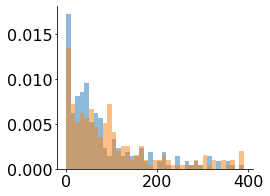

In [4]:
# path = "/home/diego/python/generative-glm/cool_stuff/p110509b_dots_mat_diego.h5"
path = "./huk_p110509b_dots.h5"
f = h5py.File(path, "r")

mask_spikes = np.array(np.stack((f['spk']), axis=1), dtype=bool)
t = np.arange(0, mask_spikes.shape[0], 1)
dt = 1

files_folder = '/home/diego/storage/generative-glm/experiments/figure4/'

idx_train = np.arange(100, 200, 2)
idx_val = idx_train + 1

# idx = np.random.choice(mask_spikes.shape[1], size=n_train + n_val, replace=False)

st = SpikeTrain(t, mask_spikes)
mask_spikes_train = mask_spikes[:, idx_train]
# mask_spikes_train = mask_spikes[:, offset:offset + n_train]

n_spk_train = np.sum(mask_spikes_train)
fr_train = np.mean(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)
fr2_train = np.mean((np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)**2)
nll_pois_proc_train = -bernoulli_log_likelihood_poisson_process(mask_spikes_train)
autocov_train = np.mean(auto_covariance(mask_spikes_train, method='fft', subtract_mean=False, 
                                        stationary_signal=False, biased=False), 1)
st_train = SpikeTrain(t, mask_spikes_train)
isi_train = st_train.isi_distribution()
mean_isi_train = np.mean(isi_train)

mask_spikes_val = mask_spikes[:, idx_val]
n_spk_val = np.sum(mask_spikes_val)
fr_val = np.mean(np.sum(mask_spikes_val, 0) / (t[-1] - t[0] + t[1]) * 1000)
nll_pois_proc_val = -bernoulli_log_likelihood_poisson_process(mask_spikes_val)
autocov_val = np.mean(auto_covariance(mask_spikes_val, method='fft', subtract_mean=False, 
                                        stationary_signal=False, biased=False), 1)

st_val = SpikeTrain(t, mask_spikes_val)
isi_val = st_val.isi_distribution()
mean_isi_val = np.mean(isi_val)

bins_isi = np.arange(0, 400, 10)
fig, ax = plt.subplots()
ax.hist(isi_train, density=True, alpha=0.5, bins=bins_isi);
ax.hist(isi_val, density=True, alpha=0.5, bins=bins_isi);

In [5]:
def fun_metrics_ml(model, t, mask_spikes, X, n_batch_fr=None):
    T = st_train.t[-1] - st_train.t[0] + st_train.t[1]
    u_dc_val, r_dc_val = model.sample_conditioned(st_val.t, st_val.mask)
    nll_val = -(np.sum(np.log(1 - np.exp(-dt * r_dc_val[st_val.mask]) + 1e-24) ) - \
                dt * np.sum(r_dc_val[~st_val.mask]))
    u_fr, r_fr, mask_spikes_fr = model.sample(st_train.t, shape=(n_batch_fr,))
    fr = np.sum(mask_spikes_fr, 0) / T * 1000
    mu_fr = np.mean(fr)
    return dict(mu_fr=mu_fr, nll_val=nll_val)

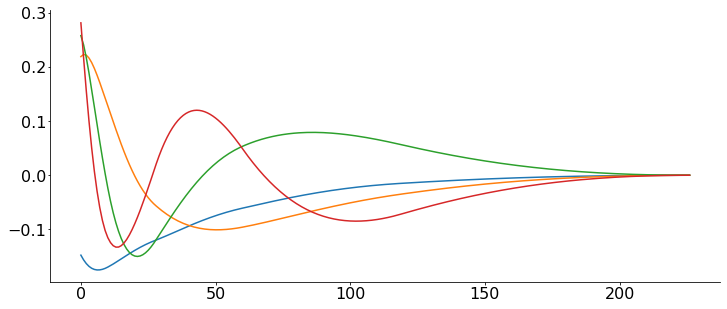

In [218]:
def raised_cosine(t, b, c, dc, a=1e0):
    basis = (1 + np.cos(np.maximum(-np.pi, np.minimum(a * (np.log(t + b) - c) * np.pi / dc / 2, np.pi)))) / 2
    basis = basis / np.sqrt(np.sum(basis**2, 0))
    u, s, v = np.linalg.svd(basis)
    basis = u[:, :basis.shape[1]]
    return basis

# n = 6
# last_peak = 400
# b = last_peak / 5

# n = 8
# last_peak = 300
# b = last_peak / 5

n = 6
last_peak = 60
b = last_peak / 5

peak0 = 0

yrnge = np.log(np.array([0, last_peak]) + b)
db = np.diff(yrnge) / (n - 1)
ctrs = np.arange(yrnge[0], yrnge[1] + db, db)
mxt = np.exp(yrnge[1] + 2 * db) - b
t_ker = np.arange(0, mxt[-1] + dt, dt)
# t_ker = np.arange(0,)

basis = raised_cosine(t_ker[:, None], b, ctrs[None, :], db)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(t_ker, basis)

## load ml

In [7]:
files_folder = '/home/diego/storage/generative-glm/experiments/figure4/'
with open(files_folder + 'ml2.pk', "rb") as fit_file:
    dic_ml = pickle.load(fit_file)
eta_ml = KernelBasisValues(dic_ml['basis'], [0, dic_ml['basis'].shape[0]], 1, coefs=dic_ml['eta_coefs'])
glm_ml = TorchGLM(u0=dic_ml['u0_ml'], eta=eta_ml)
nll_normed_train_ml = dic_ml['nll_normed_train_ml']
nll_normed_val_ml = dic_ml['nll_normed_val_ml']
bins_ks = dic_ml['bins_ks']

r_train_dc_ml, r_val_dc_ml, r_fr_ml, mask_spikes_fr_ml = dic_ml['r_train_dc_ml'], dic_ml['r_val_dc_ml'], dic_ml['r_fr_ml'], dic_ml['mask_spikes_fr_ml']

st_fr_ml = SpikeTrain(st_val.t, mask_spikes_fr_ml)
isi_fr_ml = st_fr_ml.isi_distribution()
mean_isi_fr_ml = np.mean(isi_fr_ml)
mean_r_fr_ml = np.mean(r_fr_ml, 1)
sum_r_fr_ml = np.sum(r_fr_ml, 1)
autocov_ml = np.mean(auto_covariance(mask_spikes_fr_ml, method='fft', subtract_mean=False, stationary_signal=False, biased=False), 1)

z_ml_train, ks_ml_train = time_rescale_transform(dt, st_train.mask, r_train_dc_ml)
values, bins_ks = np.histogram(np.concatenate(z_ml_train), bins=bins_ks)
z_cum_ml_train = np.append(0., np.cumsum(values) / np.sum(values))

z_ml_val, ks_ml_val = time_rescale_transform(dt, st_val.mask, r_val_dc_ml)
values, _ = np.histogram(np.concatenate(z_ml_val), bins=bins_ks)
z_cum_ml_val = np.append(0., np.cumsum(values) / np.sum(values))

### MMD

In [8]:
# def fun_metrics_mmd(model, t, mask_spikes, mask_spikes_fr):
#     T_train = t[-1] - t[0] + t[1]
#     fr = np.sum(mask_spikes_fr.double().numpy(), 0) / T_train * 1000
#     mu_fr = np.mean(fr) 
#     b_grad_norm = (model.b.grad.detach().norm(2)**0.5).item()
#     eta_coefs_grad_norm = (model.eta_coefs.grad.detach().norm(2)**0.5).item()
#     return dict(mu_fr=mu_fr, min_fr=np.min(fr), max_fr=np.max(fr), b=model.b.detach().item(), eta_coefs=model.eta_coefs.detach().numpy(), b_grad_norm=b_grad_norm, eta_coefs_grad_norm=eta_coefs_grad_norm)

def fun_metrics_mmd(model, t, mask_spikes, mask_spikes_fr):
    T_train = t[-1] - t[0] + t[1]
    fr = np.sum(mask_spikes_fr.double().numpy(), 0) / T_train * 1000
    mu_fr = np.mean(fr)
    max_fr = np.max(fr)
    min_fr = np.min(fr)
    b_grad = model.b.grad.detach().item()
    eta0_grad = model.eta_coefs.grad.detach().numpy().copy()
#     print(eta0_grad)
#     b_grad = model.eta_coefs.grad.detach()
    return dict(mu_fr=mu_fr, max_fr=max_fr, min_fr=min_fr, mu2_fr=np.mean(fr**2), b_grad=b_grad, eta0_grad=eta0_grad)

In [224]:
def phi_mean_fr(t, mask_spikes):
    T = t[-1] - t[0] + t[1]
    return torch.sum(mask_spikes, 0).double()[None, :] * 1000 / T

def phi_var_fr(t, mask_spikes):
    T = t[-1] - t[0] + t[1]
    fr = torch.sum(mask_spikes, 0).double()[None, :] * 1000 / T
    mean_fr = torch.mean(fr)
    return (fr - mean_fr)**2

def phi_mean_var_fr(t, mask_spikes):
    T = t[-1] - t[0] + t[1]
    fr = torch.sum(mask_spikes, 0).double()[None, :] * 1000 / T
    mean_fr = torch.mean(fr)
#     return (fr + 1)**2
    return torch.cat((fr, fr**2, fr**3, fr**4), 0)

def phi_mean_fr_log(t, mask_spikes):
    T = t[-1] - t[0] + t[1]
    return torch.log(torch.sum(mask_spikes, 0).double()[None, :] * 1000 / T + 1e-20)

def phi_mean_fr_squared(t, mask_spikes):
    T = t[-1] - t[0] + t[1]
    fr = torch.sum(mask_spikes, 0).double()[None, :] * 1000 / T
    return fr + fr**2

def phi_cum(t, mask_spikes):
    cum = torch.cumsum(mask_spikes.double(), dim=0)
    return cum

def phi_autocov(t, mask_spikes, argf=200):
    autocor = auto_covariance(mask_spikes.numpy(), subtract_mean=False, stationary_signal=False, biased=False)
    autocor = torch.from_numpy(autocor[:argf])
    return autocor

def ker_autocov(t, mask_spikes1, mask_spikes2):
    autocor1 = auto_covariance(mask_spikes1.numpy(), subtract_mean=False, stationary_signal=False, biased=False)
    autocor1 = torch.from_numpy(autocor1[:250])
    autocor2 = auto_covariance(mask_spikes2.numpy(), subtract_mean=False, stationary_signal=False, biased=False)
    autocor2 = torch.from_numpy(autocor2[:250])
#     print(autocor)
#     print(autocor.shape)
#     print(knkww)
#     autocov = conv1d(eta.T[None, :, :], eta.T[:, None, :], padding=padding, groups=eta.shape[1]) / T
#     autocov = autocov[0, :, (padding-1):].T
    return torch.sum(autocor1[:, :, None] * autocor2[:, None, :], dim=0)

def ker_expautocov(t, mask_spikes1, mask_spikes2):
    autocor1 = auto_covariance(mask_spikes1.numpy(), subtract_mean=False, stationary_signal=False, biased=False)
    autocor1 = torch.from_numpy(autocor1[:250])
    autocor2 = auto_covariance(mask_spikes2.numpy(), subtract_mean=False, stationary_signal=False, biased=False)
    autocor2 = torch.from_numpy(autocor2[:250])
    gramian = torch.exp(-torch.sum((autocor1[:, :, None] - autocor2[:, None, :])**2, dim=0) / sd2)
#     print(torch.sum((autocor1[:, :, None] - autocor2[:, None, :])**2, dim=0))
#     print(gramian)
#     print(kwknwk)
    return gramian

def ker_muisi(t, mask_spikes1, mask_spikes2):
    isi1 = SpikeTrain(t, mask_spikes1.numpy()).isi_distribution(concatenate=False)
    isi2 = SpikeTrain(t, mask_spikes2.numpy()).isi_distribution(concatenate=False)
    isi1 = torch.tensor([np.mean(_isi) if len(_isi) > 0 else t[-1] for _isi in isi1])
    isi2 = torch.tensor([np.mean(_isi) if len(_isi) > 0 else t[-1] for _isi in isi2])
    return isi1[:, None] * isi2[None, :]

def ker_fr(t, mask_spikes1, mask_spikes2):
    T = t[-1] - t[0] + t[1]
    fr1 = torch.sum(mask_spikes1, 0).double() * 1000 / T
    fr2 = torch.sum(mask_spikes2, 0).double() * 1000 / T
    return fr1[:, None] * fr2[None, :]

def ker_var_fr(t, mask_spikes1, mask_spikes2):
    T = t[-1] - t[0] + t[1]
    fr1 = torch.sum(mask_spikes1, 0).double() * 1000 / T
    fr2 = torch.sum(mask_spikes2, 0).double() * 1000 / T
    mean_fr1 = torch.mean(fr1)
    mean_fr2 = torch.mean(fr2)
    return (fr1 - mean_fr1)[:, None]**2 * (fr2 - mean_fr2)[None, :]**2

def ker_expfr(t, mask_spikes1, mask_spikes2, sd2=1e4):
    T = t[-1] - t[0] + t[1]
    fr1 = torch.sum(mask_spikes1, 0).double() * 1000 / T
    fr2 = torch.sum(mask_spikes2, 0).double() * 1000 / T
#     gramian = torch.exp(-torch.sum((fr1[:, None] - fr2[None, :])**2, 0) / sd2)
    gramian = torch.exp(-(fr1[:, None] - fr2[None, :])**2 / sd2)
    return gramian

def ker_expfr_sum(t, mask_spikes1, mask_spikes2, sd2s=(1e6,)):
    T = t[-1] - t[0] + t[1]
    fr1 = torch.sum(mask_spikes1, 0).double() * 1000 / T
    fr2 = torch.sum(mask_spikes2, 0).double() * 1000 / T
    diff_fr = (fr1[:, None] - fr2[None, :])**2
#     gramian = torch.exp(-diff_cum / 5e5)
    gramian = torch.exp(-diff_fr / sd2s[0]) * sd2s[0]
    for sd2 in sd2s[1:]:
        gramian = gramian + torch.exp(-diff_fr / sd2) * sd2
#     gramian += torch.exp(-(fr1[:, None] - fr2[None, :])**2 / 5e3)
#     gramian += torch.exp(-(fr1[:, None] - fr2[None, :])**2 / 5e1)
    return gramian

def ker_expfrautocov(t, mask_spikes1, mask_spikes2):
    T = t[-1] - t[0] + t[1]
    fr1 = torch.sum(mask_spikes1, 0).double() * 1000 / T
    fr2 = torch.sum(mask_spikes2, 0).double() * 1000 / T
    autocor1 = auto_covariance(mask_spikes1.numpy(), subtract_mean=False, stationary_signal=False, biased=False)
    autocor1 = torch.from_numpy(autocor1[:250])
    autocor2 = auto_covariance(mask_spikes2.numpy(), subtract_mean=False, stationary_signal=False, biased=False)
    autocor2 = torch.from_numpy(autocor2[:250])
    gramian = 1e4 * torch.exp(-torch.sum((fr1[:, None] - fr2[None, :])**2, 0) / 1e7) + \
              1e6 * torch.exp(-torch.sum((autocor1[:, :, None] - autocor2[:, None, :])**2, dim=0) / 1e-3)
    return gramian

def ker_sch_heavi(t, mask_spikes1, mask_spikes2, sd2s=(1e6,)):
    cum1 = torch.cumsum(mask_spikes1, dim=0)
    cum2 = torch.cumsum(mask_spikes2, dim=0)
    diff_cum = torch.sum((cum1[:, :, None] - cum2[:, None, :])**2, dim=0)
#     diff_cum = torch.sum(torch.abs(cum1[:, :, None] - cum2[:, None, :]), dim=0)
    gramian = torch.exp(-diff_cum / sd2s[0]) * sd2s[0]
    for sd2 in sd2s[1:]:
        gramian = gramian + torch.exp(-diff_cum / sd2) * sd2
    return gramian

dic_ker_strings = {'phi_mean_fr': "fr*fr'", 'phi_mean_fr_squared': "fr^2*fr^2'", 'phi_mean_fr_log': "logfr*logfr'",
                   "phi_var_fr": "(fr**2-mean(fr))*(fr'**2-mean(fr'))",
                   'ker_fr': "fr*fr'", 'ker_expfr': "exp(-(fr - fr')^2 / sd2)", 'ker_expfr_sum': "exp(-(fr - fr')^2 / sd2)", 'phi_autocov': 's*s', 
                  'ker_sch_heavi': 'exp(-sum((cum1 - cum2)^2 / sd2)', 'ker_autocov': 's*s', 'ker_muisi': 'muisi', 
                  'ker_expautocov': "exp(-(C - C')^2 / sd2)", 
                  'ker_expfrautocov': "exp(-(C - C')^2 / sd2) + samewithfr"}
dic_ker_name = {'phi_mean_fr': "product", 'phi_mean_fr_squared': 'product_squared', 'phi_mean_fr_log': 'product_logs',
                "phi_var_fr": "product_minus_mean_squared", 
                'ker_fr': 'product', 'ker_expfr': "gaussian_fr", 'ker_expfr_sum': "gaussian_fr", 'phi_autocov': 'autocov', 
               'ker_sch_heavi': 'schoenberg', 'ker_autocov': 'autocov', 'ker_muisi': 'muisi', 
               'ker_expautocov': 'gaussian_autocov', 
               'ker_expfrautocov': "gaussian_fr_autocov"}

In [209]:
from torch.optim.lr_scheduler import ExponentialLR, StepLR

In [220]:
kernel_kwargs = None
n_samples = 2000
# phi, kernel, lam_mmd, biased, lr, clip = None, ker_fr, 1e1, False, 1e-3, 1e0 # hard to get it to match fr
# phi, kernel, lam_mmd, biased, lr, clip, sd2 = None, ker_expfr, 1e4, True, 1e-2, 5e-1, 1e7 # works good with high nbumber of samples
# phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs, initialization, kernel_kwargs = None, ker_sch_heavi, 1e0, False, 2e-3, None, 800, 800, 'zero', dict(sd2s=[1e6, 1e4, 1e2])
# phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs, initialization, kernel_kwargs = None, ker_expfr_sum, 1e0, False, 5e-3, None, 800, 150, 'zero', dict(sd2s=[1e6, 1e4, 1e2, 1e1])
phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs, initialization, kernel_kwargs = phi_autocov, None, 5e6, True, 2e-3, None, 800, 450, 'zero', dict(argf=250)

# phi, kernel, lam_mmd, biased, lr, clip, sd2, n_batch_fr = None, ker_expfr, 5e4, True, 1e-2, 5e-1, 1e7, 400 # works good with high nbumber of samples

# phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs, initialization = phi_mean_fr, None, 1e0, False, 5e-2, None, 800, 100, 'zero'
# phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs, initialization = phi_mean_fr, None, 1e3, True, 1e-2, None, 800, 120, 'zero'
# phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs, initialization = phi_mean_var_fr, None, 5e-5, True, 1e-2, 5e-1, 800, 800, 'zero'

# phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs, initialization = phi_cum, None, 1e0, True, 1e-2, None, 800, 120, 'zero'

# phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs, initialization = phi_var_fr, None, 5e-1, True, 5e-2, 5e-1, 800, 100, 'zero'

# phi, kernel, lam_mmd, biased, lr, clip, sd2, n_batch_fr, num_epochs = phi_mean_fr, None, 1e0, True, 1e-2, None, 1e7, 800, 600

# phi, kernel, lam_mmd, biased, lr, clip, sd2, n_batch_fr, num_epochs = phi_mean_fr, None, 1e0, False, 1e-2, None, 1e7, 3200, 600

# seems like the firing rate match is small enough than no progress is made. true mean 3, samples mean 6
# phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs = phi_mean_fr, None, 5e2, True, 1e-2, None, 24000, 800

# doesnt seem to work
# phi, kernel, lam_mmd, biased, lr, clip, sd2, n_batch_fr = phi_mean_fr_log, None, 5e1, True, 1e-2, None, 1e7, 4800

# soso
# phi, kernel, lam_mmd, biased, lr, clip, sd2, n_batch_fr = phi_mean_fr_squared, None, 1e-4, True, 1e-2, None, 1e7, 4800

# phi, kernel, lam_mmd, biased, lr, clip, sd2, n_batch_fr, num_epochs = phi_mean_fr_squared, None, 5e-7, False, 5e-3, None, 5e5, 1600, 1000

# phi, kernel, lam_mmd, biased, lr, clip, sd2, n_batch_fr, num_epochs = phi_mean_fr_squared, None, 1e0, False, 1e-1, None, 5e5, 1600, 800

# phi, kernel, lam_mmd, biased, lr, clip, sd2, n_batch_fr, num_epochs = phi_var_fr, None, 5e-6, False, 5e-3, None, 5e5, 1600, 400

# phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs = phi_var_fr, None, 5e-3, True, 1e-2, None, 24000, 400

# phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs = None, ker_var_fr, 1e0, True, 1e-2, None, 800, 100

# beta0, beta1 = 0.95, 0.99
beta0, beta1 = 0, 0
n_metrics = 1
log_likelihood = False
control_variates = False

dtime = datetime.now()
dtime = str(dtime.year) + '/' + str(dtime.month) + '/' + str(dtime.day) + '-' + str(dtime.hour) + ':' + str(dtime.minute) + ':' + str(dtime.second)

time0 = time.time()
u00 = glm_ml.u0
eta0 = glm_ml.eta.copy()
if initialization == 'zero':
    eta0.coefs = eta0.coefs * 0
#     eta0 = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=np.zeros(basis.shape[1]))

# eta0.coefs = glm_ml.eta.coefs.copy() * 0.4

mmdglm = MMDGLM(u0=u00, eta=eta0)
optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1), amsgrad=False)
# optim = torch.optim.SGD(mmdglm.parameters(), lr=1e-10)
# optim = torch.optim.Adagrad(mmdglm.parameters(), lr=lr, lr_decay=0)
# scheduler = ExponentialLR(optim, 0.9975**1000)
# scheduler = ExponentialLR(optim, 0.997)
# scheduler = StepLR(optim, 75, gamma=0.75)
# scheduler = StepLR(optim, 250, gamma=0.1)
scheduler = None

loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                log_likelihood=log_likelihood,
                                               n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, kernel_kwargs=kernel_kwargs, optim=optim, clip=clip, 
                                                num_epochs=num_epochs, scheduler=scheduler, 
                                              verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics, control_variates=control_variates)
loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
nll_normed_train_mmd = (nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
iterations_mmd = np.arange(1, num_epochs + 1, 1)

_, r_dc_mmd_train = mmdglm.sample_conditioned(st_train.t, st_train.mask)
z_mmd_train, ks_mmd_train = time_rescale_transform(dt, st_train.mask, r_dc_mmd_train)
values, bins_ks = np.histogram(np.concatenate(z_mmd_train), bins=bins_ks)
z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

_, r_dc_mmd_val = mmdglm.sample_conditioned(st_val.t, st_val.mask)
_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_val.t, shape=(n_samples,))
st_fr_mmd = SpikeTrain(st_train.t, mask_spikes_fr_mmd)
fr_mmd = np.sum(mask_spikes_fr_mmd, 0) / (dt * mask_spikes_fr_mmd.shape[0]) * 1000
print(np.max(fr_mmd), np.mean(fr_mmd), np.mean(fr_mmd**2), np.std(fr_mmd))
print(np.std(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000), np.mean((np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)**2))
isi_fr_mmd = st_fr_mmd.isi_distribution()
mean_isi_fr_mmd = np.mean(isi_fr_mmd)
autocov_mmd = np.mean(auto_covariance(mask_spikes_fr_mmd, method='fft', 
                                           subtract_mean=False, stationary_signal=False, biased=False), 1)
rmse_autocov = np.sqrt(np.mean((autocov_mmd - autocov_train)**2))
nll_val_mmd = -(np.sum(np.log(1 - np.exp(-dt * r_dc_mmd_val[st_val.mask]) + 1e-24) ) - \
            dt * np.sum(r_dc_mmd_val[~st_val.mask]))
nll_normed_val_mmd = (nll_val_mmd - nll_pois_proc_val) / np.log(2) / n_spk_val
z_mmd_val, ks_mmd_val = time_rescale_transform(dt, st_val.mask, r_dc_mmd_val)
values, bins_ks = np.histogram(np.concatenate(z_mmd_val), bins=bins_ks)
z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

r_dc_mmd_train, r_fr_mmd = r_dc_mmd_train * 1000, r_fr_mmd * 1000
r_dc_mmd_val = r_dc_mmd_val * 1000

time1 = time.time()
etime = (time1 - time0) / 60
print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

mmd_mmd = MMD(t, torch.from_numpy(st_train.mask), torch.from_numpy(mask_spikes_fr_mmd), phi=phi, kernel=kernel, biased=biased).item()

# if phi is not None:
#     n_d = st_train.mask.shape[1]
#     phi_d = phi(torch.from_numpy(t), torch.from_numpy(st_train.mask))
#     phi_fr = phi(torch.from_numpy(t), torch.from_numpy(mask_spikes_fr_mmd))
#     if biased:
#         phi_d_mean = torch.mean(phi_d, 1).detach()
#         phi_fr_mean = torch.mean(phi_fr, 1).detach()
#         mmd_mmd = float(torch.sum((phi_d_mean - phi_fr_mean)**2))
#     else:
#         sum_phi_d = torch.sum(phi_d, 1).detach()
#         sum_phi_fr = torch.sum(phi_fr, 1).detach()
#         norm2_d = (torch.sum(sum_phi_d**2) - torch.sum(phi_d.detach()**2)) / (n_d * (n_d - 1))
#         norm2_fr = (torch.sum(sum_phi_fr**2) - torch.sum(phi_fr.detach()**2)) / (n_batch_fr * (n_batch_fr - 1))
#         mean_dot = torch.sum(sum_phi_d * sum_phi_fr) / (n_d * n_batch_fr)     
#         mmd_mmd = norm2_d + norm2_fr - 2 * mean_dot
# else:
#     gramian_d_d = kernel(t, torch.from_numpy(mask_spikes_train), torch.from_numpy(mask_spikes_train))
#     gramian_fr_fr = kernel(t, torch.from_numpy(mask_spikes_fr_mmd), torch.from_numpy(mask_spikes_fr_mmd))
#     gramian_d_fr = kernel(t, torch.from_numpy(mask_spikes_train), torch.from_numpy(mask_spikes_fr_mmd))
#     if biased:
#         mmd_mmd = float(torch.mean(gramian_d_d.detach()) + torch.mean(gramian_fr_fr.detach()) \
#             - 2 * torch.mean(gramian_d_fr.detach()))
#     else:
#         idx_fr = np.triu_indices(n_batch_fr, k=1)
#         idx_fr = (torch.from_numpy(idx_fr[0]), torch.from_numpy(idx_fr[1]))
#         idx_d = np.triu_indices(mask_spikes_train.shape[1], k=1)
#         idx_d = (torch.from_numpy(idx_d[0]), torch.from_numpy(idx_d[1]))
#         mmd_mmd = float(torch.mean(gramian_d_d.detach()[idx_d]) + torch.mean(gramian_fr_fr.detach()[idx_fr]) \
#                                           - 2 * torch.mean(gramian_d_fr.detach()))

 epoch 449 of 450 loss -152.458465086213.223140495867769 4.614876033057851 25.394440270473332 2.0241935357029375
3.3559825198573177 32.07431186394373

 took 115.15993309020996 seconds 1.919332218170166 minutes


In [200]:
def after_metrics(model, t, mask_spikes, mask_spikes_fr):
    b_grad = model.b.grad.detach().item()
    eta_coefs_grad = model.eta_coefs.grad.detach().clone().numpy()
    T_train = t[-1] - t[0] + t[1]
    fr = np.sum(mask_spikes_fr.double().numpy(), 0) / T_train * 1000
    mu_fr = np.mean(fr) 
    fr_max = np.max(fr)
    return dict(b_grad=b_grad, eta_coefs_grad=eta_coefs_grad, mu_fr=mu_fr, fr_max=fr_max)

mmdglm_after = MMDGLM(u0=mmdglm.u0, eta=mmdglm.eta.copy())

_loss_mmd, _nll_train, metrics_after = mmdglm_after.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                log_likelihood=False, n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, 
                                                kernel_kwargs=kernel_kwargs, optim=torch.optim.SGD(mmdglm_after.parameters(), lr=0),
                                               num_epochs=50, verbose=True, metrics=after_metrics, n_metrics=1, control_variates=False)

mmd_mean = np.mean(metrics_after['mmd'])
mmd_sd = np.std(metrics_after['mmd'])
params_grad = np.concatenate((np.array(metrics_after['b_grad'])[:, None], np.array(metrics_after['eta_coefs_grad'])), axis=1)
params_grad_mean = np.mean(params_grad, 0)
params_grad_cov = np.cov(params_grad.T)

fr_mean_mean, fr_mean_sd = np.mean(metrics_after['mu_fr']), np.std(metrics_after['mu_fr'])
fr_max_mean, fr_max_sd = np.mean(metrics_after['fr_max']), np.std(metrics_after['fr_max'])
print('\nmmd', mmd_mean, mmd_sd)

 epoch 49 of 50 loss -12.96194461873
mmd 2.1652266180388633e-07 8.4986542457097e-09


In [221]:
# cum1 = torch.cumsum(torch.from_numpy(mask_spikes_train), dim=0)
# cum2 = torch.cumsum(torch.from_numpy(mask_spikes_fr_mmd), dim=0)
# diff_cum = torch.sum((cum1[:, :, None] - cum2[:, None, :])**2, dim=0)
# diff_cum = diff_cum.numpy()
# print(np.mean(diff_cum), np.min(diff_cum), np.max(diff_cum))
# print(np.exp(-diff_cum / 1e4))

# cum1 = torch.cumsum(torch.from_numpy(mask_spikes_fr_mmd), dim=0)
# cum2 = torch.cumsum(torch.from_numpy(mask_spikes_fr_mmd), dim=0)
# diff_cum = torch.sum((cum1[:, :, None] - cum2[:, None, :])**2, dim=0)
# diff_cum = diff_cum.numpy()
# print(np.mean(diff_cum), np.min(diff_cum), np.max(diff_cum))
# print(np.exp(-diff_cum / 1e4))

IndexError: index 4 is out of bounds for axis 1 with size 4

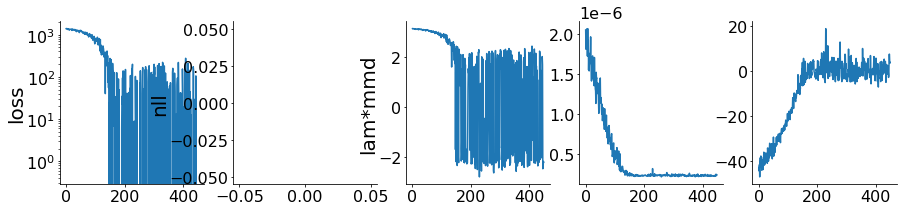

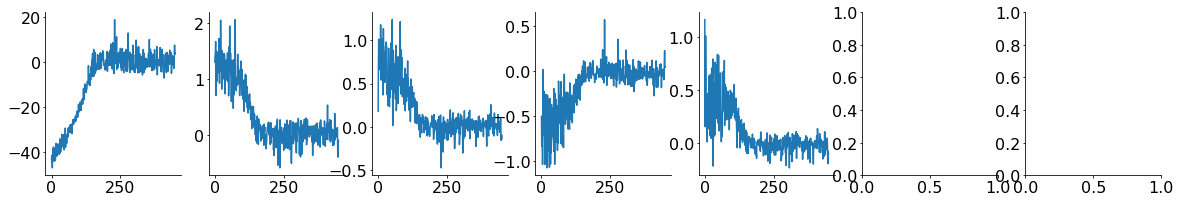

In [222]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(15, 3), ncols=5)
ax1.plot(loss_mmd)
ax1.set_ylabel('loss')
ax1.set_yscale('log')
ax2.plot(nll_normed_train_mmd)
ax2.set_ylabel('nll')
_nll_train = nll_train if nll_train is not None and len(nll_train) > 0 else np.zeros(len(loss_mmd))
mmd_surr = loss_mmd - _nll_train
mmd_surr[mmd_surr > 0] = np.log10(mmd_surr[mmd_surr > 0])
mmd_surr[mmd_surr < 0] = -np.log10(-mmd_surr[mmd_surr < 0])
ax3.plot(mmd_surr)
ax3.set_ylabel('lam*mmd')
# ax3.set_yscale('log')
mmd_plot = metrics_mmd['mmd'].copy()
# mmd_plot[mmd_plot > 0] = np.log10(mmd_plot[mmd_plot > 0])
# mmd_plot[mmd_plot < 0] = -np.log10(-mmd_plot[mmd_plot < 0])
ax4.plot(mmd_plot)
# ax4.set_yscale('log')
ax5.plot(metrics_mmd['b_grad'])
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(figsize=(20, 3), ncols=7)
eta_grad = np.array(metrics_mmd['eta0_grad'])
ax1.plot(metrics_mmd['b_grad'])
ax2.plot(eta_grad[:, 0])
ax3.plot(eta_grad[:, 1])
ax4.plot(eta_grad[:, 2])
ax5.plot(eta_grad[:, 3])
ax6.plot(eta_grad[:, 4])
ax7.plot(eta_grad[:, 5])
# ax2.plot(metrics_mmd['eta0_grad'][4])

2.2524698698417034e-07 7.1378790412338115e-09


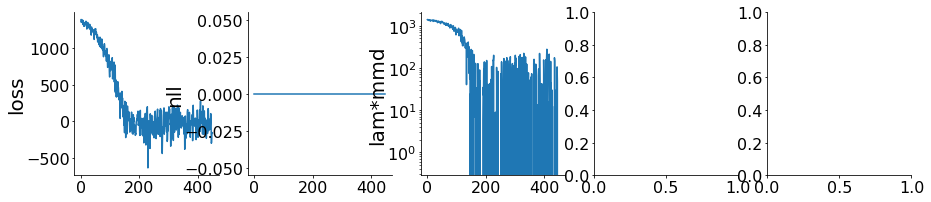

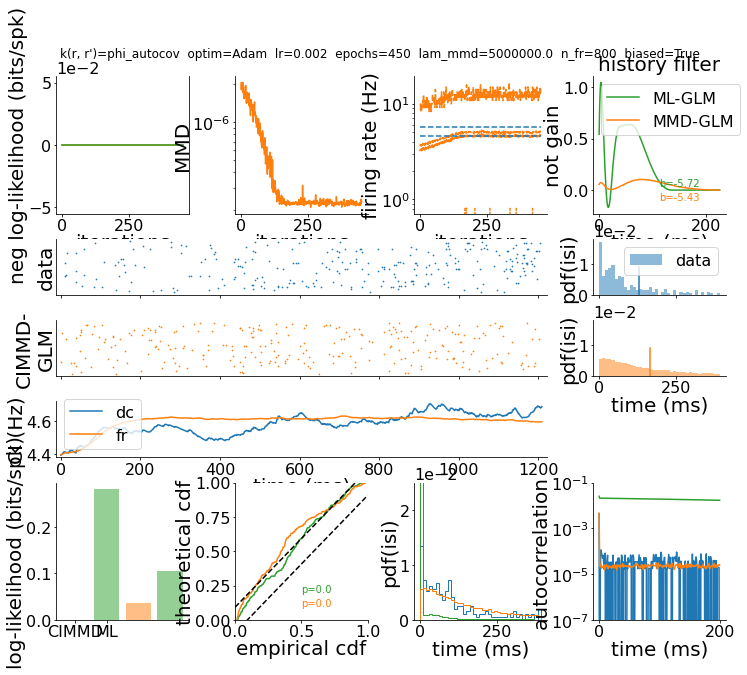

In [223]:
for key, val in metrics_mmd.items():
    metrics_mmd[key] = np.array(val)

if phi is not None:
    ker_name = phi.__name__
else:
    ker_name = kernel.__name__
    
title = "k(r, r')=" + ker_name + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
     + '  epochs=' + str(num_epochs) + \
       '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased)

if nll_train is None or len(nll_train)==0:
    nll_train = np.zeros(len(iterations_mmd))
    nll_normed_train_mmd = np.zeros(len(iterations_mmd))

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(15, 3), ncols=5)
ax1.plot(loss_mmd)
ax1.set_ylabel('loss')
ax2.plot(nll_train)
ax2.set_ylabel('nll')
if np.mean(loss_mmd - nll_train) > 0:
    ax3.plot(loss_mmd - nll_train)
else:
    ax3.plot(-(loss_mmd - nll_train))
ax3.set_ylabel('lam*mmd')
ax3.set_yscale('log')
# ax4.plot(metrics_mmd['b_grad_norm'])
# ax4.set_yscale('log')
# ax5.plot(metrics_mmd['eta_coefs_grad_norm'])
# ax5.set_yscale('log')

ncols = 4
r1, r2 = 2, 1
nrows = 2 * r1 + 3 * r2

fig, (ax00, ax01, ax02, ax03, ax10, ax11, ax20, ax21, ax30, ax40, ax41, ax42, ax43) = plot_layout()
fig.suptitle(title, fontsize=12, y=0.92)

ax00.plot(iterations_mmd, nll_normed_train_mmd, '-', label='train', color=palette['mmd'])
ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_normed_train_mmd[0], nll_normed_train_mmd[0]], '-', 
          label='ML-GLM', color=palette['ml'])
ax00.spines['right'].set_visible(True)
ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax00.legend()
myplt.set_labels(ax00, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')

mm = 100
print(np.mean(metrics_mmd['mmd'][-mm:]), np.std(metrics_mmd['mmd'][-mm:]))
ax01.plot(iterations_mmd[::n_metrics], metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
yf = np.median(metrics_mmd['mmd'][-10:] * 2)
ax01.set_yscale('log')
# ax01.set_ylim(-1e2, yf)
myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

ax02.plot(iterations_mmd[::n_metrics], metrics_mmd['mu_fr'], label='MMD-GLM', color=palette['mmd'])
ax02.plot(iterations_mmd[::n_metrics], metrics_mmd['min_fr'], label='MMD-GLM', color=palette['mmd'], linestyle='dotted')
ax02.plot(iterations_mmd[::n_metrics], metrics_mmd['max_fr'], color=palette['mmd'], linestyle='--')
ax02.plot(iterations_mmd[::n_metrics], metrics_mmd['mu2_fr']**0.5, color=palette['mmd'], linestyle='--')
ax02.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_train, fr_train], '--', label='data', color=palette['d'])
ax02.plot([iterations_mmd[0], iterations_mmd[-1]], [fr2_train**0.5, fr2_train**0.5], '--', label='data', color=palette['d'])
ax02.set_yscale('log')
# ax02b = ax02.twinx()
# ax02b.plot(iterations_mmd[::n_metrics], metrics_mmd['max_fr'], color=palette['mmd'], linestyle='--')
# ax10.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_val, fr_val], '--', label='data', color=palette['d'])
myplt.set_labels(ax02, xlabel='iterations', ylabel='firing rate (Hz)')
# ax02.legend()

glm_ml.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='ML-GLM', color=palette['ml'])
mmdglm.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='MMD-GLM', color=palette['mmd'])
myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
ax03.text(0.5, 0.2, 'b=' + str(np.round(glm_ml.u0, 2)), color=palette['ml'], transform=ax03.transAxes)
ax03.text(0.5, 0.1, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax03.transAxes)
ax03.legend()
# ax03.set_ylim(-0.4, 0.2)

ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins_isi)
ax11.legend()
y1 = ax11.get_ylim()[1] / 2
ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
ax11.set_ylabel('pdf(isi)')
ax11.tick_params(axis='both', labelbottom=False)

# ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
# ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins_isi)
ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
ax10.set_yticks([])
ax10.set_ylabel('data')

# st_fr_mmd.plot(ax=ax20, ms=0.7, color=palette['mmd'])
st_fr_mmd.sweeps(np.arange(st_train.mask.shape[1])).plot(ax=ax20, ms=0.7, color=palette['mmd'])
ax20.tick_params(axis='both', labelbottom=False, labelleft=False)
ax20.set_yticks([])
ax20.set_ylabel('CIMMD-\nGLM')

ax30.plot(t, np.mean(r_dc_mmd_val, 1), color=palette['d'], label='dc')
ax30.plot(t, np.mean(r_fr_mmd, 1), color=palette['mmd'], label='fr')
# ax30.plot(t_long, np.mean(r_train_dc_ml, 1), color=palette['ml'], label='ML-FR')

ax30.legend()
myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

ax40.bar(0, -nll_normed_train_mmd[-1], alpha=0.5, color=palette['mmd'], label='CIMMD-GLM')
ax40.bar(1, -nll_normed_train_ml[-1], alpha=0.5, color=palette['ml'], label='ML-GLM')
ax40.bar(2, -nll_normed_val_mmd, alpha=0.5, color=palette['mmd'], label='CIMMD-GLM')
ax40.bar(3, -nll_normed_val_ml[-1], alpha=0.5, color=palette['ml'], label='ML-GLM')
# ax40.legend()
ax40.set_ylabel('log-likelihood (bits/spk)')
ax40.set_xticks([0, 1])
ax40.set_xticklabels(['CIMMD', 'ML'])

# ax40.set_ylabel('log-likelihood (bits/spk)')

ax41.plot(bins_ks, z_cum_ml_val, color=palette['ml'], label='ML-GLM')
ax41.plot(bins_ks, z_cum_mmd_val, color=palette['mmd'], label='CIMMD-GLM')
x = np.array([0, 1])
ax41.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
ax41.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
myplt.set_labels(ax41, xlabel='empirical cdf', ylabel='theoretical cdf')
ax41.set_xlim(0, 1); ax41.set_ylim(0, 1)
ax41.text(0.5, 0.2, 'p=' + str(np.round(ks_ml_val[1], 2)), color=palette['ml'], transform=ax41.transAxes)
ax41.text(0.5, 0.1, 'p=' + str(np.round(ks_mmd_val[1], 2)), color=palette['mmd'], transform=ax41.transAxes)

lw = 1
# ax42.hist(isi_train, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins)
ax42.hist(isi_val, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins_isi)
ax42.hist(isi_fr_ml, density=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins_isi)
ax42.hist(isi_fr_mmd, density=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='CIMMD-GLM', bins=bins_isi)
ax42.set_ylim(0, 0.025)
ax42.set_ylabel('pdf(isi)')
ax42.set_xlabel('time (ms)')
ax42.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax42.legend()
# y1 = ax42.get_ylim()[1] / 2
# ax42.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
# ax42.tick_params(axis='both', labelbottom=False)

argf = 200
ax43.plot(autocov_val[:argf], color=palette['d'], label='data')
ax43.plot(autocov_ml[:argf], color=palette['ml'], label='ML-GLM')
ax43.plot(autocov_mmd[:argf], color=palette['mmd'], label='MMD-GLM')
ax43.set_ylim(1e-7, 1e-1)
ax43.set_yscale('log')
myplt.set_labels(ax43, xlabel='time (ms)', ylabel='autocorrelation')

# fig.subplots_adjust(hspace=0.35)
fig.subplots_adjust(hspace=0.45, wspace=0.35)

In [169]:
list_files = os.listdir('/home/diego/storage/generative-glm/experiments/figure4/')

file_name = 'mmd_' + ker_name + '_' + 'lammmd' + str(lam_mmd) + 'biased' + str(biased) +  \
           '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)
ii = 1
while file_name + '_' + str(ii) + '.pk' in list_files:
    ii += 1
file_name = file_name + '_' + str(ii) + '.pk'


# fig.savefig('/home/diego/storage/generative-glm/experiments/figure4/' + fig_name, transparent=True)

dic = dict(server=os.uname()[1], dtime=dtime, idx_train=idx_train, idx_val=idx_val, basis=basis, 
           u0_ml=glm_ml.u0, eta_coefs_ml=glm_ml.eta.coefs, ker_name=ker_name, 
           lam_mmd=lam_mmd, biased=biased, lr=lr, clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd, nll_train=nll_normed_train_mmd, 
           nll_normed_val_mmd=nll_normed_val_mmd, metrics_mmd=metrics_mmd, u0_mmd=mmdglm.u0, eta_coefs_mmd=mmdglm.eta.coefs)

path = '/home/diego/storage/generative-glm/experiments/figure4/' + file_name
with open(path, "wb") as fit_file:
    pickle.dump(dic, fit_file)
    
# dic_df = dict(server=os.uname()[1], dtime=dtime, idx_train=idx_train, idx_val=idx_val, mmd_ker='score_function', ker_name=ker_name, n_basis=n, 
#               last_peak=last_peak, 
#                 lam_mmd=lam_mmd, biased=biased, lr=lr, clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd[-1], nll_train=nll_normed_train_mmd[-1], 
#               nll_normed_val_mmd=nll_normed_val_mmd, fr_mmd_m=np.mean(fr_mmd), fr_mmd_max=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
#               u0=mmdglm.u0, eta_coefs=mmdglm.eta.coefs)

ker_kwargs = None if kernel_kwargs is None else list(kernel_kwargs.values())
dic_df = dict(file_name=file_name, server=os.uname()[1], dtime=dtime, idx_train=idx_train, idx_val=idx_val, mmd_ker='score_function', ker_name=ker_name, n_basis=n, 
              last_peak=last_peak, num_epochs=num_epochs, log_likelihood=log_likelihood, control_variates=control_variates, 
                lam_mmd=lam_mmd, biased=biased, lr=lr, beta0=beta0, beta1=beta1, clip=clip, n_batch_fr=n_batch_fr, etime=etime, loss_mmd=loss_mmd[-1], 
                nll_train=nll_train[-1], nll_normed_train=nll_normed_train_mmd[-1], 
              nll_normed_val_mmd=nll_normed_val_mmd, fr_mmd_m=np.mean(fr_mmd), fr_mmd_max=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
              u0=mmdglm.u0, eta_coefs=mmdglm.eta.coefs, mmd_mean=mmd_mean, mmd_sd=mmd_sd, params_grad_mean=params_grad_mean, params_grad_cov=params_grad_cov, 
                fr_mean_mean=fr_mean_mean, fr_mean_sd=fr_mean_sd, fr_max_mean=fr_max_mean, fr_max_sd=fr_max_sd, initialization=initialization, 
              kernel_kwargs=ker_kwargs)

_df = pd.DataFrame(pd.Series(dic_df)).T

df = pd.read_json('./mmd_summary_new.json')
df = df.append(_df, ignore_index=True)
df.to_json('./mmd_summary_new.json', double_precision=15)

# df = pd.read_json('./mmd_summary.json')
# df = df.append(_df, ignore_index=True)
# df.to_json('./mmd_summary.json', double_precision=15)

In [48]:
df.iloc[-1].file_name

'mmd_phi_mean_fr_lammmd2000.0biasedTrue_epochs600_lr0.05_1.pk'

In [38]:
# df['file_name'] = None
# df = df[['file_name'] + list(df.columns[:-1])]
# df.to_json('./mmd_summary_new.json', double_precision=15)

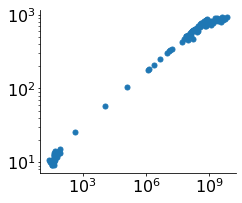

In [166]:
# # plt.figure()
# # # plt.plot(metrics_mmd['mu_fr'], metrics_mmd['max_fr'], 'o')
# # plt.plot(metrics_mmd['norm2_fr'], metrics_mmd['max_fr'], 'o')
# # # plt.plot(metrics_mmd['mmd'], metrics_mmd['max_fr'], 'o')
# # plt.yscale('log')
# # plt.xscale('log')
# plt.figure()
# plt.plot(metrics_mmd['min_fr'])
# plt.plot(metrics_mmd['mu_fr'])
# # plt.plot(metrics_mmd['max_fr'])
# plt.figure()
# # plt.plot(metrics_mmd['log_proba'][:, 3])
# # plt.plot(metrics_mmd['log_proba'][:, 0])
# # plt.plot(metrics_mmd['log_proba'][:, 2])
# plt.plot(metrics_mmd['log_proba'][:, 1])
# # plt.plot(metrics_mmd['mmd'] * 1e-7)
# # plt.plot(metrics_mmd['scores'][:, 1, 3])
# # plt.plot(metrics_mmd['mmd'], metrics_mmd['log_proba'][:, 3], 'o')
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(12, 4), ncols=4)
# ax1.plot(metrics_mmd['b'])
# ax2.plot(metrics_mmd['b_grad_norm'])
# ax3.plot(metrics_mmd['eta_coefs'])
# ax4.plot(metrics_mmd['eta_coefs_grad_norm'])
# # ax1.set_yscale('log')
# # ax2.plot(metrics_mmd['mean_dot'])
# # ax2.set_yscale('log')
# # ax3.plot(metrics_mmd['norm2_fr'], metrics_mmd['mean_dot'])
# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), ncols=3)
# ax1.plot(metrics_mmd['norm2_fr'])
# ax1.set_yscale('log')
# ax2.plot(metrics_mmd['mean_dot'])
# ax2.set_yscale('log')
# ax3.plot(metrics_mmd['norm2_fr'], metrics_mmd['mean_dot'])

In [28]:
pars_mean_fr = list(itertools.product([2e3], [0], [0], [800], ['ml', 'zero']))
pars_mean_fr = pars_mean_fr * 2
# pars_var_fr = list(itertools.product([3e-2, 4e-2], [0], [0], [800], ['ml', 'zero']))
# pars_var_fr = pars_var_fr * 10
# pars_exp_fr = list(itertools.product([3e5, 5e5, 7e5], [0], [0, 0.999], ['ml', 'zero'], [1e3]))
# pars_exp_fr = pars_exp_fr * 5

for lam_mmd, beta0, beta1, n_batch_fr, initialization in pars_mean_fr:
    phi, kernel, biased, lr, clip, num_epochs, kernel_kwargs = phi_mean_fr, None, True, 5e-2, None, 1200, None
# for lam_mmd, beta0, beta1, n_batch_fr, initialization in pars_var_fr:
#     phi, kernel, biased, lr, clip, num_epochs, kernel_kwargs = phi_var_fr, None, True, 1e-2, None, 1200, None
# for lam_mmd, beta0, beta1, initialization, sd2 in pars_exp_fr:
#     phi, kernel, biased, lr, clip, n_batch_fr, num_epochs, kernel_kwargs = None, ker_expfr, False, 1e-2, None, 800, 1200, dict(sd2=sd2)

    kernel_kwargs = None

#     phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs, initialization = phi_mean_fr, None, 2e3, True, 5e-2, 5e-1, 800, 600, 'zero'

    beta0, beta1 = 0, 0
    n_metrics = 5
    log_likelihood = True
    control_variates = False

    dtime = datetime.now()
    dtime = str(dtime.year) + '/' + str(dtime.month) + '/' + str(dtime.day) + '-' + str(dtime.hour) + ':' + str(dtime.minute) + ':' + str(dtime.second)

    time0 = time.time()
    u00 = glm_ml.u0
    eta0 = glm_ml.eta.copy()
    if initialization == 'zero':
        eta0.coefs = eta0.coefs * 0

    mmdglm = MMDGLM(u0=u00, eta=eta0)
    optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1), amsgrad=False)
    scheduler = None

    loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                    log_likelihood=log_likelihood,
                                                   n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, kernel_kwargs=kernel_kwargs, optim=optim, clip=clip, 
                                                    num_epochs=num_epochs, scheduler=scheduler, 
                                                  verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics, control_variates=control_variates)
    loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
    nll_normed_train_mmd = (nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
    metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
    iterations_mmd = np.arange(1, num_epochs + 1, 1)

    _, r_dc_mmd_train = mmdglm.sample_conditioned(st_train.t, st_train.mask)
    z_mmd_train, ks_mmd_train = time_rescale_transform(dt, st_train.mask, r_dc_mmd_train)
    values, bins_ks = np.histogram(np.concatenate(z_mmd_train), bins=bins_ks)
    z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

    _, r_dc_mmd_val = mmdglm.sample_conditioned(st_val.t, st_val.mask)
    _, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_val.t, shape=(8000,))
    st_fr_mmd = SpikeTrain(st_train.t, mask_spikes_fr_mmd)
    fr_mmd = np.sum(mask_spikes_fr_mmd, 0) / (dt * mask_spikes_fr_mmd.shape[0]) * 1000
    print(np.max(fr_mmd), np.mean(fr_mmd), np.mean(fr_mmd**2), np.std(fr_mmd))
    print(np.std(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000), np.mean((np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)**2))
    isi_fr_mmd = st_fr_mmd.isi_distribution()
    mean_isi_fr_mmd = np.mean(isi_fr_mmd)
    autocov_mmd = np.mean(auto_covariance(mask_spikes_fr_mmd, method='fft', 
                                               subtract_mean=False, stationary_signal=False, biased=False), 1)
    rmse_autocov = np.sqrt(np.mean((autocov_mmd - autocov_train)**2))
    nll_val_mmd = -(np.sum(np.log(1 - np.exp(-dt * r_dc_mmd_val[st_val.mask]) + 1e-24) ) - \
                dt * np.sum(r_dc_mmd_val[~st_val.mask]))
    nll_normed_val_mmd = (nll_val_mmd - nll_pois_proc_val) / np.log(2) / n_spk_val
    z_mmd_val, ks_mmd_val = time_rescale_transform(dt, st_val.mask, r_dc_mmd_val)
    values, bins_ks = np.histogram(np.concatenate(z_mmd_val), bins=bins_ks)
    z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

    r_dc_mmd_train, r_fr_mmd = r_dc_mmd_train * 1000, r_fr_mmd * 1000
    r_dc_mmd_val = r_dc_mmd_val * 1000

    time1 = time.time()
    etime = (time1 - time0) / 60
    print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

    mmd_mmd = MMD(t, torch.from_numpy(st_train.mask), torch.from_numpy(mask_spikes_fr_mmd), phi=phi, kernel=kernel, biased=biased).item()

    def after_metrics(model, t, mask_spikes, mask_spikes_fr):
        b_grad = model.b.grad.detach().item()
        eta_coefs_grad = model.eta_coefs.grad.detach().clone().numpy()
        T_train = t[-1] - t[0] + t[1]
        fr = np.sum(mask_spikes_fr.double().numpy(), 0) / T_train * 1000
        mu_fr = np.mean(fr) 
        fr_max = np.max(fr)
        return dict(b_grad=b_grad, eta_coefs_grad=eta_coefs_grad, mu_fr=mu_fr, fr_max=fr_max)

    mmdglm_after = MMDGLM(u0=mmdglm.u0, eta=mmdglm.eta.copy())

    _loss_mmd, _nll_train, metrics_after = mmdglm_after.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                    log_likelihood=False, n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, 
                                                    kernel_kwargs=kernel_kwargs, optim=torch.optim.SGD(mmdglm_after.parameters(), lr=0),
                                                   num_epochs=50, verbose=True, metrics=after_metrics, n_metrics=1, control_variates=False)

    mmd_mean = np.mean(metrics_after['mmd'])
    mmd_sd = np.std(metrics_after['mmd'])
    params_grad = np.concatenate((np.array(metrics_after['b_grad'])[:, None], np.array(metrics_after['eta_coefs_grad'])), axis=1)
    params_grad_mean = np.mean(params_grad, 0)
    params_grad_cov = np.cov(params_grad.T)

    fr_mean_mean, fr_mean_sd = np.mean(metrics_after['mu_fr']), np.std(metrics_after['mu_fr'])
    fr_max_mean, fr_max_sd = np.mean(metrics_after['fr_max']), np.std(metrics_after['fr_max'])
    print('\nmmd', mmd_mean, mmd_sd)

    for key, val in metrics_mmd.items():
        metrics_mmd[key] = np.array(val)

    if phi is not None:
        ker_name = phi.__name__
    else:
        ker_name = kernel.__name__

    title = "k(r, r')=" + ker_name + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
         + '  epochs=' + str(num_epochs) + \
           '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased)

    if nll_train is None or len(nll_train)==0:
        nll_train = np.zeros(len(iterations_mmd))
        nll_normed_train_mmd = np.zeros(len(iterations_mmd))

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(15, 3), ncols=5)
    ax1.plot(loss_mmd)
    ax1.set_ylabel('loss')
    ax2.plot(nll_train)
    ax2.set_ylabel('nll')
    if np.mean(loss_mmd - nll_train) > 0:
        ax3.plot(loss_mmd - nll_train)
    else:
        ax3.plot(-(loss_mmd - nll_train))
    ax3.set_ylabel('lam*mmd')
    ax3.set_yscale('log')
    # ax4.plot(metrics_mmd['b_grad_norm'])
    # ax4.set_yscale('log')
    # ax5.plot(metrics_mmd['eta_coefs_grad_norm'])
    # ax5.set_yscale('log')

    ncols = 4
    r1, r2 = 2, 1
    nrows = 2 * r1 + 3 * r2

    fig, (ax00, ax01, ax02, ax03, ax10, ax11, ax20, ax21, ax30, ax40, ax41, ax42, ax43) = plot_layout()
    fig.suptitle(title, fontsize=12, y=0.92)

    ax00.plot(iterations_mmd, nll_normed_train_mmd, '-', label='train', color=palette['mmd'])
    ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_normed_train_mmd[0], nll_normed_train_mmd[0]], '-', 
              label='ML-GLM', color=palette['ml'])
    ax00.spines['right'].set_visible(True)
    ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # ax00.legend()
    myplt.set_labels(ax00, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')

    mm = 100
    print(np.mean(metrics_mmd['mmd'][-mm:]), np.std(metrics_mmd['mmd'][-mm:]))
    ax01.plot(iterations_mmd[::n_metrics], metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
    ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    yf = np.median(metrics_mmd['mmd'][-10:] * 2)
    ax01.set_yscale('log')
    # ax01.set_ylim(-1e2, yf)
    myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

    ax02.plot(iterations_mmd[::n_metrics], metrics_mmd['mu_fr'], label='MMD-GLM', color=palette['mmd'])
    ax02b = ax02.twinx()
    ax02b.plot(iterations_mmd[::n_metrics], metrics_mmd['max_fr'], color=palette['mmd'], linestyle='--')
    ax02.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_train, fr_train], '--', label='data', color=palette['d'])
    # ax10.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_val, fr_val], '--', label='data', color=palette['d'])
    myplt.set_labels(ax02, xlabel='iterations', ylabel='firing rate (Hz)')
    # ax02.legend()

    glm_ml.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='ML-GLM', color=palette['ml'])
    mmdglm.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='MMD-GLM', color=palette['mmd'])
    myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
    ax03.text(0.5, 0.2, 'b=' + str(np.round(glm_ml.u0, 2)), color=palette['ml'], transform=ax03.transAxes)
    ax03.text(0.5, 0.1, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax03.transAxes)
    ax03.legend()
    # ax03.set_ylim(-0.4, 0.2)

    ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins_isi)
    ax11.legend()
    y1 = ax11.get_ylim()[1] / 2
    ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
    ax11.set_ylabel('pdf(isi)')
    ax11.tick_params(axis='both', labelbottom=False)

    # ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
    # ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
    ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins_isi)
    ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
    myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
    ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
    ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
    ax10.set_yticks([])
    ax10.set_ylabel('data')

    # st_fr_mmd.plot(ax=ax20, ms=0.7, color=palette['mmd'])
    st_fr_mmd.sweeps(np.arange(st_train.mask.shape[1])).plot(ax=ax20, ms=0.7, color=palette['mmd'])
    ax20.tick_params(axis='both', labelbottom=False, labelleft=False)
    ax20.set_yticks([])
    ax20.set_ylabel('CIMMD-\nGLM')

    ax30.plot(t, np.mean(r_dc_mmd_val, 1), color=palette['d'], label='dc')
    ax30.plot(t, np.mean(r_fr_mmd, 1), color=palette['mmd'], label='fr')
    # ax30.plot(t_long, np.mean(r_train_dc_ml, 1), color=palette['ml'], label='ML-FR')

    ax30.legend()
    myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

    ax40.bar(0, -nll_normed_train_mmd[-1], alpha=0.5, color=palette['mmd'], label='CIMMD-GLM')
    ax40.bar(1, -nll_normed_train_ml[-1], alpha=0.5, color=palette['ml'], label='ML-GLM')
    ax40.bar(2, -nll_normed_val_mmd, alpha=0.5, color=palette['mmd'], label='CIMMD-GLM')
    ax40.bar(3, -nll_normed_val_ml[-1], alpha=0.5, color=palette['ml'], label='ML-GLM')
    # ax40.legend()
    ax40.set_ylabel('log-likelihood (bits/spk)')
    ax40.set_xticks([0, 1])
    ax40.set_xticklabels(['CIMMD', 'ML'])

    # ax40.set_ylabel('log-likelihood (bits/spk)')

    ax41.plot(bins_ks, z_cum_ml_val, color=palette['ml'], label='ML-GLM')
    ax41.plot(bins_ks, z_cum_mmd_val, color=palette['mmd'], label='CIMMD-GLM')
    x = np.array([0, 1])
    ax41.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
    ax41.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
    myplt.set_labels(ax41, xlabel='empirical cdf', ylabel='theoretical cdf')
    ax41.set_xlim(0, 1); ax41.set_ylim(0, 1)
    ax41.text(0.5, 0.2, 'p=' + str(np.round(ks_ml_val[1], 2)), color=palette['ml'], transform=ax41.transAxes)
    ax41.text(0.5, 0.1, 'p=' + str(np.round(ks_mmd_val[1], 2)), color=palette['mmd'], transform=ax41.transAxes)

    lw = 1
    # ax42.hist(isi_train, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins)
    ax42.hist(isi_val, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins_isi)
    ax42.hist(isi_fr_ml, density=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins_isi)
    ax42.hist(isi_fr_mmd, density=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='CIMMD-GLM', bins=bins_isi)
    ax42.set_ylim(0, 0.025)
    ax42.set_ylabel('pdf(isi)')
    ax42.set_xlabel('time (ms)')
    ax42.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # ax42.legend()
    # y1 = ax42.get_ylim()[1] / 2
    # ax42.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
    # ax42.tick_params(axis='both', labelbottom=False)

    argf = 200
    ax43.plot(autocov_val[:argf], color=palette['d'], label='data')
    ax43.plot(autocov_ml[:argf], color=palette['ml'], label='ML-GLM')
    ax43.plot(autocov_mmd[:argf], color=palette['mmd'], label='MMD-GLM')
    ax43.set_ylim(1e-7, 1e-1)
    ax43.set_yscale('log')
    myplt.set_labels(ax43, xlabel='time (ms)', ylabel='autocorrelation')

    # fig.subplots_adjust(hspace=0.35)
    fig.subplots_adjust(hspace=0.45, wspace=0.35)

    list_files = os.listdir('/home/diego/storage/generative-glm/experiments/figure4/')

    file_name = 'mmd_' + ker_name + '_' + 'lammmd' + str(lam_mmd) + 'biased' + str(biased) +  \
               '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)
    ii = 1
    while file_name + '_' + str(ii) + '.pk' in list_files:
        ii += 1
    file_name = file_name + '_' + str(ii) + '.pk'


    # fig.savefig('/home/diego/storage/generative-glm/experiments/figure4/' + fig_name, transparent=True)

    dic = dict(server=os.uname()[1], dtime=dtime, idx_train=idx_train, idx_val=idx_val, basis=basis, 
               u0_ml=glm_ml.u0, eta_coefs_ml=glm_ml.eta.coefs, ker_name=ker_name, 
               lam_mmd=lam_mmd, biased=biased, lr=lr, clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd, nll_train=nll_normed_train_mmd, 
               nll_normed_val_mmd=nll_normed_val_mmd, metrics_mmd=metrics_mmd, u0_mmd=mmdglm.u0, eta_coefs_mmd=mmdglm.eta.coefs)

    path = '/home/diego/storage/generative-glm/experiments/figure4/' + file_name
    with open(path, "wb") as fit_file:
        pickle.dump(dic, fit_file)

    # dic_df = dict(server=os.uname()[1], dtime=dtime, idx_train=idx_train, idx_val=idx_val, mmd_ker='score_function', ker_name=ker_name, n_basis=n, 
    #               last_peak=last_peak, 
    #                 lam_mmd=lam_mmd, biased=biased, lr=lr, clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd[-1], nll_train=nll_normed_train_mmd[-1], 
    #               nll_normed_val_mmd=nll_normed_val_mmd, fr_mmd_m=np.mean(fr_mmd), fr_mmd_max=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
    #               u0=mmdglm.u0, eta_coefs=mmdglm.eta.coefs)

    ker_kwargs = None if kernel_kwargs is None else list(kernel_kwargs.values())
    dic_df = dict(file_name=file_name, server=os.uname()[1], dtime=dtime, idx_train=idx_train, idx_val=idx_val, mmd_ker='score_function', ker_name=ker_name, n_basis=n, 
                  last_peak=last_peak, num_epochs=num_epochs, log_likelihood=log_likelihood, control_variates=control_variates, 
                    lam_mmd=lam_mmd, biased=biased, lr=lr, beta0=beta0, beta1=beta1, clip=clip, n_batch_fr=n_batch_fr, etime=etime, loss_mmd=loss_mmd[-1], 
                    nll_train=nll_train[-1], nll_normed_train=nll_normed_train_mmd[-1], 
                  nll_normed_val_mmd=nll_normed_val_mmd, fr_mmd_m=np.mean(fr_mmd), fr_mmd_max=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
                  u0=mmdglm.u0, eta_coefs=mmdglm.eta.coefs, mmd_mean=mmd_mean, mmd_sd=mmd_sd, params_grad_mean=params_grad_mean, params_grad_cov=params_grad_cov, 
                    fr_mean_mean=fr_mean_mean, fr_mean_sd=fr_mean_sd, fr_max_mean=fr_max_mean, fr_max_sd=fr_max_sd, initialization=initialization, 
                  kernel_kwargs=ker_kwargs)

    _df = pd.DataFrame(pd.Series(dic_df)).T

    df = pd.read_json('./mmd_summary_new.json')
    df = df.append(_df, ignore_index=True)
    df.to_json('./mmd_summary_new.json', double_precision=15)
    
    plt.close('all')

    # df = pd.read_json('./mmd_summary.json')
    # df = df.append(_df, ignore_index=True)
    # df.to_json('./mmd_summary.json', double_precision=15)

 epoch 1199 of 1200 loss -601837.34979216032och 91 of 1200 loss -3976015.987502834epoch 396 of 1200 loss -2970807.9537455epoch 901 of 1200 loss -4216923.337567115814.0495867768594 5.061466942148761 1203.2023939621608 34.315943034625995
3.3559825198573177 32.07431186394373

 took 220.18266320228577 seconds 3.6697110533714294 minutes
 epoch 49 of 50 loss -3375687.4258031267
mmd 2.1389802182227977 3.2812526165807028
2.179968357267262 4.36617294341132
 epoch 1199 of 1200 loss -12061649.216444042ss -28975.2361542848360 of 1200 loss 95098.7745935852380 of 1200 loss 14991.2407068822 -5378958.614314439epoch 1098 of 1200 loss -5061947.712753027epoch 1132 of 1200 loss -5584023.071557125 loss -3370568.9544559717825.6198347107438 3.875619834710744 520.4209070418688 22.481113805562778
3.3559825198573177 32.07431186394373

 took 223.43704748153687 seconds 3.7239507913589476 minutes
 epoch 49 of 50 loss 445449.288343611323
mmd 1.0304325182706093 1.187377166479376
0.8368827799501397 1.5567092684718602

In [ ]:
# dic_sd2 = {}

pars_mean_fr = list(itertools.product([5e2], [0], [0], [800], ['ml', 'zero']))
pars_mean_fr = pars_mean_fr * 3
# pars_var_fr = list(itertools.product([1e-2, 2e-2, 3e-2, 4e-2], [0], [0, 0.9, 0.999], [800], ['ml', 'zero']))
# pars_var_fr = pars_var_fr * 5
# pars_exp_fr = list(itertools.product([3e5, 5e5, 7e5], [0], [0, 0.999], ['ml', 'zero'], [1e3]))
# pars_exp_fr = pars_exp_fr * 5

for lam_mmd, beta0, beta1, n_batch_fr, initialization in pars_mean_fr:
    phi, kernel, biased, lr, clip, num_epochs, kernel_kwargs = phi_mean_fr, None, True, 1e-2, None, 600, None
# for lam_mmd, beta0, beta1, n_batch_fr, initialization in pars_var_fr:
#     phi, kernel, biased, lr, clip, num_epochs, kernel_kwargs = phi_var_fr, None, True, 1e-2, None, 1200, None
# for lam_mmd, beta0, beta1, initialization, sd2 in pars_exp_fr:
#     phi, kernel, biased, lr, clip, n_batch_fr, num_epochs, kernel_kwargs = None, ker_expfr, False, 1e-2, None, 800, 1200, dict(sd2=sd2)
# for lam_mmd, beta0, beta1, sd2 in itertools.product([5e1, 5e2, 5e3], [0, 0.9], [0, 0.9, 0.99, 0.999], [1e0, 1e2, 1e4, 1e6]):
#     phi, kernel, lr, clip, n_batch_fr, num_epochs = None, ker_expfr, 1e-2, None, 800, 400
#     phi, kernel, lam_mmd, biased, lr, clip, sd2, n_batch_fr = phi_mean_fr, None, 2e1, True, 1e-2, 5e-1, 1e7, 800
    n_metrics = 5
    log_likelihood = True
    control_variates = False

    dtime = datetime.now()
    dtime = str(dtime.year) + '/' + str(dtime.month) + '/' + str(dtime.day) + '-' + str(dtime.hour) + ':' + str(dtime.minute) + ':' + str(dtime.second)
#     dic_sd2[dtime] = sd2

    time0 = time.time()
    u00 = glm_ml.u0
    eta0 = glm_ml.eta.copy()
    if initialization == 'zero':
        eta0.coefs = eta0.coefs * 0

    mmdglm = MMDGLM(u0=u00, eta=eta0)
    optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1), amsgrad=False)
    # optim = torch.optim.SGD(mmdglm.parameters(), lr=1e-10)
    # optim = torch.optim.Adagrad(mmdglm.parameters(), lr=lr, lr_decay=0)
    # scheduler = ExponentialLR(optim, 0.9975**1000)
    # scheduler = ExponentialLR(optim, 0.997)
    # scheduler = StepLR(optim, 75, gamma=0.75)
    # scheduler = StepLR(optim, 250, gamma=0.1)
    scheduler = None

    loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                    log_likelihood=log_likelihood,
                                                   n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, kernel_kwargs=kernel_kwargs, optim=optim, clip=clip, 
                                                    num_epochs=num_epochs, scheduler=scheduler, 
                                                  verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics, control_variates=control_variates)
    loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
    nll_normed_train_mmd = (nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
    metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
    iterations_mmd = np.arange(1, num_epochs + 1, 1)

    _, r_dc_mmd_train = mmdglm.sample_conditioned(st_train.t, st_train.mask)
    z_mmd_train, ks_mmd_train = time_rescale_transform(dt, st_train.mask, r_dc_mmd_train)
    values, bins_ks = np.histogram(np.concatenate(z_mmd_train), bins=bins_ks)
    z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

    _, r_dc_mmd_val = mmdglm.sample_conditioned(st_val.t, st_val.mask)
    _, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_val.t, shape=(8000,))
    st_fr_mmd = SpikeTrain(st_train.t, mask_spikes_fr_mmd)
    fr_mmd = np.sum(mask_spikes_fr_mmd, 0) / (dt * mask_spikes_fr_mmd.shape[0]) * 1000
    print(np.max(fr_mmd), np.mean(fr_mmd), np.mean(fr_mmd**2), np.std(fr_mmd))
    print(np.std(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000), np.mean((np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)**2))
    isi_fr_mmd = st_fr_mmd.isi_distribution()
    mean_isi_fr_mmd = np.mean(isi_fr_mmd)
    autocov_mmd = np.mean(auto_covariance(mask_spikes_fr_mmd, method='fft', 
                                               subtract_mean=False, stationary_signal=False, biased=False), 1)
    rmse_autocov = np.sqrt(np.mean((autocov_mmd - autocov_train)**2))
    nll_val_mmd = -(np.sum(np.log(1 - np.exp(-dt * r_dc_mmd_val[st_val.mask]) + 1e-24) ) - \
                dt * np.sum(r_dc_mmd_val[~st_val.mask]))
    nll_normed_val_mmd = (nll_val_mmd - nll_pois_proc_val) / np.log(2) / n_spk_val
    z_mmd_val, ks_mmd_val = time_rescale_transform(dt, st_val.mask, r_dc_mmd_val)
    values, bins_ks = np.histogram(np.concatenate(z_mmd_val), bins=bins_ks)
    z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

    r_dc_mmd_train, r_fr_mmd = r_dc_mmd_train * 1000, r_fr_mmd * 1000
    r_dc_mmd_val = r_dc_mmd_val * 1000

    time1 = time.time()
    etime = (time1 - time0) / 60
    print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

    mmd_mmd = MMD(t, torch.from_numpy(st_train.mask), torch.from_numpy(mask_spikes_fr_mmd), phi=phi, kernel=kernel, biased=biased).item()

    def after_metrics(model, t, mask_spikes, mask_spikes_fr):
        b_grad = model.b.grad.detach().item()
        eta_coefs_grad = model.eta_coefs.grad.detach().clone().numpy()
        T_train = t[-1] - t[0] + t[1]
        fr = np.sum(mask_spikes_fr.double().numpy(), 0) / T_train * 1000
        mu_fr = np.mean(fr) 
        fr_max = np.max(fr)
        return dict(b_grad=b_grad, eta_coefs_grad=eta_coefs_grad, mu_fr=mu_fr, fr_max=fr_max)

    mmdglm_after = MMDGLM(u0=mmdglm.u0, eta=mmdglm.eta.copy())

    _loss_mmd, _nll_train, metrics_after = mmdglm_after.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                    log_likelihood=False, n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, 
                                                    kernel_kwargs=kernel_kwargs, optim=torch.optim.SGD(mmdglm_after.parameters(), lr=0),
                                                   num_epochs=50, verbose=True, metrics=after_metrics, n_metrics=1, control_variates=False)

    mmd_mean = np.mean(metrics_after['mmd'])
    mmd_sd = np.std(metrics_after['mmd'])
    params_grad = np.concatenate((np.array(metrics_after['b_grad'])[:, None], np.array(metrics_after['eta_coefs_grad'])), axis=1)
    params_grad_mean = np.mean(params_grad, 0)
    params_grad_cov = np.cov(params_grad.T)

    fr_mean_mean, fr_mean_sd = np.mean(metrics_after['mu_fr']), np.std(metrics_after['mu_fr'])
    fr_max_mean, fr_max_sd = np.mean(metrics_after['fr_max']), np.std(metrics_after['fr_max'])
    print('\nmmd', mmd_mean, mmd_sd)

    for key, val in metrics_mmd.items():
        metrics_mmd[key] = np.array(val)

    if phi is not None:
        ker_name = phi.__name__
    else:
        ker_name = kernel.__name__

    title = "k(r, r')=" + ker_name + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
         + '  epochs=' + str(num_epochs) + \
           '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased)

    if nll_train is None or len(nll_train)==0:
        nll_train = np.zeros(len(iterations_mmd))
        nll_normed_train_mmd = np.zeros(len(iterations_mmd))

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(15, 3), ncols=5)
    ax1.plot(loss_mmd)
    ax1.set_ylabel('loss')
    ax2.plot(nll_train)
    ax2.set_ylabel('nll')
    if np.mean(loss_mmd - nll_train) > 0:
        ax3.plot(loss_mmd - nll_train)
    else:
        ax3.plot(-(loss_mmd - nll_train))
    ax3.set_ylabel('lam*mmd')
    ax3.set_yscale('log')
    # ax4.plot(metrics_mmd['b_grad_norm'])
    # ax4.set_yscale('log')
    # ax5.plot(metrics_mmd['eta_coefs_grad_norm'])
    # ax5.set_yscale('log')

    ncols = 4
    r1, r2 = 2, 1
    nrows = 2 * r1 + 3 * r2

    fig, (ax00, ax01, ax02, ax03, ax10, ax11, ax20, ax21, ax30, ax40, ax41, ax42, ax43) = plot_layout()
    fig.suptitle(title, fontsize=12, y=0.92)

    ax00.plot(iterations_mmd, nll_normed_train_mmd, '-', label='train', color=palette['mmd'])
    ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_normed_train_mmd[0], nll_normed_train_mmd[0]], '-', 
              label='ML-GLM', color=palette['ml'])
    ax00.spines['right'].set_visible(True)
    ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # ax00.legend()
    myplt.set_labels(ax00, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')

    mm = 100
    print(np.mean(metrics_mmd['mmd'][-mm:]), np.std(metrics_mmd['mmd'][-mm:]))
    ax01.plot(iterations_mmd[::n_metrics], metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
    ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    yf = np.median(metrics_mmd['mmd'][-10:] * 2)
    ax01.set_yscale('log')
    # ax01.set_ylim(-1e2, yf)
    myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

    ax02.plot(iterations_mmd[::n_metrics], metrics_mmd['mu_fr'], label='MMD-GLM', color=palette['mmd'])
    ax02b = ax02.twinx()
    ax02b.plot(iterations_mmd[::n_metrics], metrics_mmd['max_fr'], color=palette['mmd'], linestyle='--')
    ax02.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_train, fr_train], '--', label='data', color=palette['d'])
    # ax10.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_val, fr_val], '--', label='data', color=palette['d'])
    myplt.set_labels(ax02, xlabel='iterations', ylabel='firing rate (Hz)')
    # ax02.legend()

    glm_ml.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='ML-GLM', color=palette['ml'])
    mmdglm.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='MMD-GLM', color=palette['mmd'])
    myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
    ax03.text(0.5, 0.2, 'b=' + str(np.round(glm_ml.u0, 2)), color=palette['ml'], transform=ax03.transAxes)
    ax03.text(0.5, 0.1, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax03.transAxes)
    ax03.legend()
    # ax03.set_ylim(-0.4, 0.2)

    ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins_isi)
    ax11.legend()
    y1 = ax11.get_ylim()[1] / 2
    ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
    ax11.set_ylabel('pdf(isi)')
    ax11.tick_params(axis='both', labelbottom=False)

    # ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
    # ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
    ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins_isi)
    ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
    myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
    ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
    ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
    ax10.set_yticks([])
    ax10.set_ylabel('data')

    # st_fr_mmd.plot(ax=ax20, ms=0.7, color=palette['mmd'])
    st_fr_mmd.sweeps(np.arange(st_train.mask.shape[1])).plot(ax=ax20, ms=0.7, color=palette['mmd'])
    ax20.tick_params(axis='both', labelbottom=False, labelleft=False)
    ax20.set_yticks([])
    ax20.set_ylabel('CIMMD-\nGLM')

    ax30.plot(t, np.mean(r_dc_mmd_val, 1), color=palette['d'], label='dc')
    ax30.plot(t, np.mean(r_fr_mmd, 1), color=palette['mmd'], label='fr')
    # ax30.plot(t_long, np.mean(r_train_dc_ml, 1), color=palette['ml'], label='ML-FR')

    ax30.legend()
    myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

    ax40.bar(0, -nll_normed_train_mmd[-1], alpha=0.5, color=palette['mmd'], label='CIMMD-GLM')
    ax40.bar(1, -nll_normed_train_ml[-1], alpha=0.5, color=palette['ml'], label='ML-GLM')
    ax40.bar(2, -nll_normed_val_mmd, alpha=0.5, color=palette['mmd'], label='CIMMD-GLM')
    ax40.bar(3, -nll_normed_val_ml[-1], alpha=0.5, color=palette['ml'], label='ML-GLM')
    # ax40.legend()
    ax40.set_ylabel('log-likelihood (bits/spk)')
    ax40.set_xticks([0, 1])
    ax40.set_xticklabels(['CIMMD', 'ML'])

    # ax40.set_ylabel('log-likelihood (bits/spk)')

    ax41.plot(bins_ks, z_cum_ml_val, color=palette['ml'], label='ML-GLM')
    ax41.plot(bins_ks, z_cum_mmd_val, color=palette['mmd'], label='CIMMD-GLM')
    x = np.array([0, 1])
    ax41.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
    ax41.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
    myplt.set_labels(ax41, xlabel='empirical cdf', ylabel='theoretical cdf')
    ax41.set_xlim(0, 1); ax41.set_ylim(0, 1)
    ax41.text(0.5, 0.2, 'p=' + str(np.round(ks_ml_val[1], 2)), color=palette['ml'], transform=ax41.transAxes)
    ax41.text(0.5, 0.1, 'p=' + str(np.round(ks_mmd_val[1], 2)), color=palette['mmd'], transform=ax41.transAxes)

    lw = 1
    # ax42.hist(isi_train, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins)
    ax42.hist(isi_val, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins_isi)
    ax42.hist(isi_fr_ml, density=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins_isi)
    ax42.hist(isi_fr_mmd, density=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='CIMMD-GLM', bins=bins_isi)
    ax42.set_ylim(0, 0.025)
    ax42.set_ylabel('pdf(isi)')
    ax42.set_xlabel('time (ms)')
    ax42.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # ax42.legend()
    # y1 = ax42.get_ylim()[1] / 2
    # ax42.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
    # ax42.tick_params(axis='both', labelbottom=False)

    argf = 200
    ax43.plot(autocov_val[:argf], color=palette['d'], label='data')
    ax43.plot(autocov_ml[:argf], color=palette['ml'], label='ML-GLM')
    ax43.plot(autocov_mmd[:argf], color=palette['mmd'], label='MMD-GLM')
    ax43.set_ylim(1e-7, 1e-1)
    ax43.set_yscale('log')
    myplt.set_labels(ax43, xlabel='time (ms)', ylabel='autocorrelation')

    # fig.subplots_adjust(hspace=0.35)
    fig.subplots_adjust(hspace=0.45, wspace=0.35)

    list_files = os.listdir('/home/diego/storage/generative-glm/experiments/figure4/')

    fig_name = 'mmd_' + ker_name + '_' + 'lammmd' + str(lam_mmd) + 'biased' + str(biased) +  \
               '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)
    ii = 1
    while fig_name + '_' + str(ii) + '.pdf' in list_files:
        ii += 1
    file_name = fig_name + '_' + str(ii) + '.pk'
    fig_name += '_' + str(ii) + '.pdf'

    # fig.savefig('/home/diego/storage/generative-glm/experiments/figure4/' + fig_name, transparent=True)

    dic = dict(server=os.uname()[1], dtime=dtime, idx_train=idx_train, idx_val=idx_val, basis=basis, 
               u0_ml=glm_ml.u0, eta_coefs_ml=glm_ml.eta.coefs, ker_name=ker_name, 
               lam_mmd=lam_mmd, biased=biased, lr=lr, clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd, nll_train=nll_normed_train_mmd, 
               nll_normed_val_mmd=nll_normed_val_mmd, metrics_mmd=metrics_mmd, u0_mmd=mmdglm.u0, eta_coefs_mmd=mmdglm.eta.coefs)

    path = '/home/diego/storage/generative-glm/experiments/figure4/' + file_name
    with open(path, "wb") as fit_file:
        pickle.dump(dic, fit_file)

    # dic_df = dict(server=os.uname()[1], dtime=dtime, idx_train=idx_train, idx_val=idx_val, mmd_ker='score_function', ker_name=ker_name, n_basis=n, 
    #               last_peak=last_peak, 
    #                 lam_mmd=lam_mmd, biased=biased, lr=lr, clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd[-1], nll_train=nll_normed_train_mmd[-1], 
    #               nll_normed_val_mmd=nll_normed_val_mmd, fr_mmd_m=np.mean(fr_mmd), fr_mmd_max=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
    #               u0=mmdglm.u0, eta_coefs=mmdglm.eta.coefs)

    ker_kwargs = None if kernel_kwargs is None else list(kernel_kwargs.values())
    dic_df = dict(server=os.uname()[1], dtime=dtime, idx_train=idx_train, idx_val=idx_val, mmd_ker='score_function', ker_name=ker_name, n_basis=n, 
                  last_peak=last_peak, num_epochs=num_epochs, log_likelihood=log_likelihood, control_variates=control_variates, 
                    lam_mmd=lam_mmd, biased=biased, lr=lr, beta0=beta0, beta1=beta1, clip=clip, n_batch_fr=n_batch_fr, etime=etime, loss_mmd=loss_mmd[-1], 
                    nll_train=nll_train[-1], nll_normed_train=nll_normed_train_mmd[-1], 
                  nll_normed_val_mmd=nll_normed_val_mmd, fr_mmd_m=np.mean(fr_mmd), fr_mmd_max=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
                  u0=mmdglm.u0, eta_coefs=mmdglm.eta.coefs, mmd_mean=mmd_mean, mmd_sd=mmd_sd, params_grad_mean=params_grad_mean, params_grad_cov=params_grad_cov, 
                    fr_mean_mean=fr_mean_mean, fr_mean_sd=fr_mean_sd, fr_max_mean=fr_max_mean, fr_max_sd=fr_max_sd, initialization=initialization, 
                  kernel_kwargs=ker_kwargs)

    _df = pd.DataFrame(pd.Series(dic_df)).T

    df = pd.read_json('./mmd_summary_new.json')
    df = df.append(_df, ignore_index=True)
    df.to_json('./mmd_summary_new.json', double_precision=15)
#     print(nkwnkwnwk)
    
    plt.close('all')

    # df = pd.read_json('./mmd_summary.json')
    # df = df.append(_df, ignore_index=True)
    # df.to_json('./mmd_summary.json', double_precision=15)
    
#     aux = '/home/diego/storage/generative-glm/experiments/figure4/' + 'dic_sd2_2.pk'
#     with open(aux, "wb") as fit_file:
#         pickle.dump(dic_sd2, fit_file)

 epoch 599 of 600 loss -213487.29936950267 -477130.3248054644epoch 501 of 600 loss -1217436.1801175633873.5537190082645 4.543595041322314 793.3998702274436 27.798482230652716
3.3559825198573177 32.07431186394373

 took 115.55356788635254 seconds 1.9258927981058755 minutes
 epoch 49 of 50 loss 80355.516266502246
mmd 1.0092921846185363 1.4739906773404206
1.2527942293900685 1.8875714332205982
 epoch 599 of 600 loss -25593.18226993794 561 of 600 loss -594042.2305799664775.2066115702479 4.787603305785123 134.7488218017895 10.574860584812683
3.3559825198573177 32.07431186394373

 took 111.8453962802887 seconds 1.8640899380048117 minutes
 epoch 49 of 50 loss -164059.15144253548
mmd 0.7351655880745855 1.7665485193474897
0.12096658143227916 0.5764414722608362
 epoch 5 of 600 loss -17824724.227976397

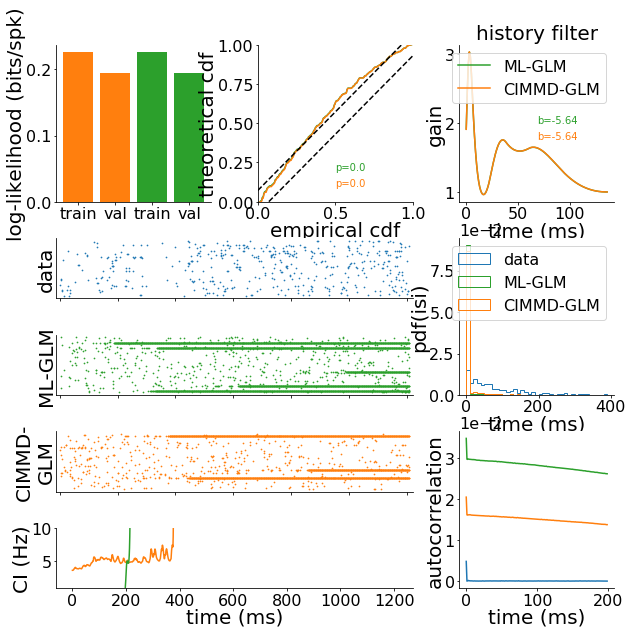

In [44]:
fig, (ax00, ax01, ax02, ax10, ax11, ax20, ax30, ax31, ax40) = plot_layout2()
fig.subplots_adjust(hspace=0.6, wspace=0.3)
# fig.suptitle('Monkey-PMv', fontsize=16, y=0.92)

ax00.bar(0, -nll_normed_train_mmd[-1], color=palette['mmd'], label='CIMMD-GLM')
ax00.bar(1, -nll_normed_val_mmd, color=palette['mmd'], label='CIMMD-GLM')
ax00.bar(2, -nll_normed_train_ml[-1], color=palette['ml'], label='ML-GLM')
ax00.bar(3, -nll_normed_val_ml[-1], color=palette['ml'], label='ML-GLM')
ax00.set_ylabel('log-likelihood (bits/spk)')
ax00.set_xticks([0, 1, 2, 3])
# ax00.set_xticklabels(['CIMMD-GLM', 'ML-GLM'])
ax00.set_xticklabels(['train', 'val', 'train', 'val'])

ax01.plot(bins_ks, z_cum_ml_val, color=palette['ml'], label='ML-GLM')
ax01.plot(bins_ks, z_cum_mmd_val, color=palette['mmd'], label='CIMMD-GLM')
x = np.array([0, 1])
ax01.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
ax01.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
myplt.set_labels(ax01, xlabel='empirical cdf', ylabel='theoretical cdf')
ax01.set_xlim(0, 1); ax01.set_ylim(0, 1)
ax01.text(0.5, 0.2, 'p=' + str(np.round(ks_ml_val[1], 2)), color=palette['ml'], transform=ax01.transAxes)
ax01.text(0.5, 0.1, 'p=' + str(np.round(ks_mmd_val[1], 2)), color=palette['mmd'], transform=ax01.transAxes)

glm.eta.plot(t=t_ker, ax=ax02, exp_values=True, label='ML-GLM', color=palette['ml'])
mmdglm.eta.plot(t=t_ker, ax=ax02, exp_values=True, label='CIMMD-GLM', color=palette['mmd'])
myplt.set_labels(ax02, xlabel='time (ms)', ylabel='gain', title='history filter')
ax02.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=ax02.transAxes)
ax02.text(0.5, 0.4, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax02.transAxes)
ax02.legend()
# ax02.set_ylim(-0.4, 0.2)

st_val.plot(ax=ax10, ms=0.7, color=palette['d'])
ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
ax10.set_yticks([])
ax10.set_ylabel('data')

st_fr_ml.plot(ax=ax20, ms=0.7, color=palette['ml'])
ax20.tick_params(axis='both', labelbottom=False, labelleft=False)
ax20.set_yticks([])
ax20.set_ylabel('ML-GLM')

lw = 1
ax11.hist(isi_val, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins_isi)
ax11.hist(isi_fr_ml, density=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins_isi)
ax11.hist(isi_fr_mmd, density=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='CIMMD-GLM', bins=bins_isi)
ax11.set_ylabel('pdf(isi)')
ax11.set_xlabel('time (ms)')
ax11.legend()
ax11.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

st_fr_mmd.plot(ax=ax30, ms=0.7, color=palette['mmd'])
ax30.tick_params(axis='both', labelbottom=False, labelleft=False)
ax30.set_yticks([])
ax30.set_ylabel('CIMMD-\nGLM')

argf = 200
ax31.plot(autocov_train[:argf], color=palette['d'], label='data')
ax31.plot(autocov_ml[:argf], color=palette['ml'], label='ML-GLM')
ax31.plot(autocov_mmd[:argf], color=palette['mmd'], label='CIMMD-GLM')
# ax31.set_ylim(0, 5e-3)
myplt.set_labels(ax31, xlabel='time (ms)', ylabel='autocorrelation')
ax31.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

alpha = 1
ax40.plot(t, np.mean(r_fr_mmd, 1), alpha=alpha, color=palette['mmd'], label='fr')
ax40.plot(t, np.mean(r_fr_ml, 1), alpha=alpha, color=palette['ml'], label='fr')
# ax40.legend()
ax40.set_ylim(0.8, 1e1)
myplt.set_labels(ax40, xlabel='time (ms)', ylabel='CI (Hz)')

fig.savefig('/home/diego/Dropbox/generative_glm/figures/fig4.pdf', transparent=True)

In [41]:
# # phi, kernel, lam_mmd, lr, clip = phi_id, None, 5e1, 1e-2, 1e0 # nice solution

# # phi, kernel, lam_mmd, lr, clip = phi_sum, None, 1e2, 1e-2, 1e0

# phi, kernel, lam_mmd, lr, clip = None, kernel_expr, 1e5, 1e-2, 1e0
# sd2 = 1e-2

# beta0, beta1 = 0, 0
# n_batch_fr = 200
# biased = False
# num_epochs = 125

# time0 = time.time()
# u00 = glm.u0
# eta0 = glm.eta.copy()

# # eta0_scaled = glm.eta.copy()
# # eta0_scaled.coefs = eta0_scaled.coefs * 0.1
# # mmdglm = CIMMDGLM(u0=glm.u0, eta=eta0_scaled.copy())

# mmdglm = CIMMDGLM(u0=u00, eta=eta0)
# optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))

# loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, log_likelihood=True, 
#                                               n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, optim=optim, clip=clip, num_epochs=num_epochs, 
#                                               verbose=True, metrics=fun_metrics_mmd, n_metrics=1)
# loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
# metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
# iterations_mmd = np.arange(1, num_epochs + 1, 1)

# _, r_dc_mmd = mmdglm.sample_conditioned(st_val.t, st_val.mask)
# _, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_val.t, shape=(st_val.mask.shape[1],))
# st_fr_mmd = SpikeTrain(st_val.t, mask_spikes_fr_mmd)
# isi_fr_mmd = st_fr_mmd.isi_distribution()
# mean_isi_fr_mmd = np.mean(isi_fr_mmd)
# r_dc_mmd, r_fr_mmd = r_dc_mmd * 1000, r_fr_mmd * 1000

# time1 = time.time()
# print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')
# # phi.__name__, kernel, lam_mmd, num_epochs, lr, clip, beta0, beta1, n_batch_fr, lam_mmd, biased
# # optim.__class__.__name__, u00, eta0, mmdglm.u0, mmdglm.eta, 

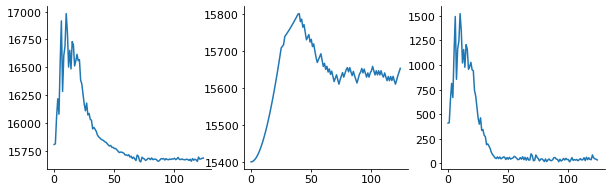

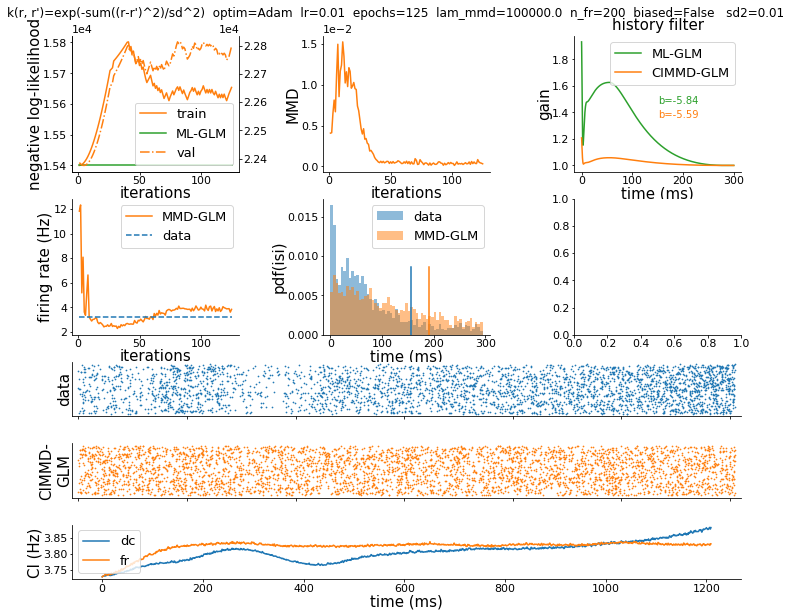

In [238]:
# for key, val in metrics_mmd.items():
#     metrics_mmd[key] = np.array(val)

# if phi is not None:
#     ker_name = phi.__name__
# else:
#     ker_name = kernel.__name__
    
# title = "k(r, r')=" + dic_ker_strings[ker_name] + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
#      + '  epochs=' + str(num_epochs) + \
#        '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased) + '   sd2=' + str(sd2)
    
# r1, r2 = 2, 1
# ncols = 3

# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
# ax1.plot(loss_mmd)
# ax2.plot(nll_train)
# ax3.plot(loss_mmd - nll_train)

# # fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), ncols=3)
# fig = plt.figure(figsize=(12, 10))
# fig.suptitle(title, fontsize=12, y=0.92)
# ax00 = plt.subplot2grid((2*r1 + 3*r2, ncols), (0, 0), rowspan=r1)
# ax01 = plt.subplot2grid((2*r1 + 3*r2, ncols), (0, 1), rowspan=r1)
# ax02 = plt.subplot2grid((2*r1 + 3*r2, ncols), (0, 2), rowspan=r1)
# ax10 = plt.subplot2grid((2*r1 + 3*r2, ncols), (r1, 0), rowspan=r1)
# ax11 = plt.subplot2grid((2*r1 + 3*r2, ncols), (r1, 1), rowspan=r1)
# ax12 = plt.subplot2grid((2*r1 + 3*r2, ncols), (r1, 2), rowspan=r1)
# ax2 = plt.subplot2grid((2*r1 + 3*r2, ncols), (2*r1, 0), colspan=ncols)
# ax3 = plt.subplot2grid((2*r1 + 3*r2, ncols), (2*r1 + r2, 0), colspan=ncols)
# ax4 = plt.subplot2grid((2*r1 + 3*r2, ncols), (2*r1 + 2*r2, 0), colspan=ncols)

# ax00.plot(iterations_mmd, nll_train, '-', label='train', color=palette['mmd'])
# ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_train[0], nll_train[0]], '-', label='ML-GLM', color=palette['ml'])
# ax00.spines['right'].set_visible(True)
# ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax00.plot(iterations_mmd[0], nll_train[0], '-.', label='val', color=palette['mmd'])
# ax00.legend()
# ax00twin = ax00.twinx()
# ax00twin.plot(iterations_mmd, metrics_mmd['nll_val'], '-.', label='val', color=palette['mmd'])
# myplt.set_labels(ax00, xlabel='iterations', ylabel='negative log-likelihood')
# ax00twin.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# ax01.plot(iterations_mmd, metrics_mmd['mmd'], label='CIMMD-GLM', color=palette['mmd'])
# # ax01.set_ylim(-1e-1, np.median(metrics_mmd['mmd'][-10:]) * 5)
# ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

# glm.eta.plot(ax=ax02, exp_values=True, label='ML-GLM', color=palette['ml'])
# mmdglm.eta.plot(ax=ax02, exp_values=True, label='CIMMD-GLM', color=palette['mmd'])
# myplt.set_labels(ax02, xlabel='time (ms)', ylabel='gain', title='history filter')
# ax02.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=ax02.transAxes)
# ax02.text(0.5, 0.4, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax02.transAxes)
# ax02.legend()

# ax10.plot(iterations_mmd, metrics_mmd['fr_fr'], label='MMD-GLM', color=palette['mmd'])
# ax10.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_val, fr_val], '--', label='data', color=palette['d'])
# myplt.set_labels(ax10, xlabel='iterations', ylabel='firing rate (Hz)')
# ax10.legend()

# bins = np.arange(0, 300, 5)
# ax11.hist(isi_val, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins)
# ax11.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
# ax11.legend()
# y1 = ax11.get_ylim()[1] / 2
# ax11.plot([mean_isi_val, mean_isi_val], [0, y1], '-', color=palette['d'])
# ax11.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
# myplt.set_labels(ax11, xlabel='time (ms)', ylabel='pdf(isi)')

# # fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=3)
# # st_train.plot(ax=ax1, ms=0.7, color=palette['d'])
# st_val.plot(ax=ax2, ms=0.7, color=palette['d'])
# ax2.tick_params(axis='both', labelbottom=False, labelleft=False)
# ax2.set_yticks([])
# ax2.set_ylabel('data')

# st_fr_mmd.plot(ax=ax3, ms=0.7, color=palette['mmd'])
# ax3.tick_params(axis='both', labelbottom=False, labelleft=False)
# ax3.set_yticks([])
# ax3.set_ylabel('CIMMD-\nGLM')

# ax4.plot(t, np.mean(r_dc_mmd, 1), color=palette['d'], label='dc')
# ax4.plot(t, np.mean(r_fr_mmd, 1), color=palette['mmd'], label='fr')
# ax4.legend()
# myplt.set_labels(ax4, xlabel='time (ms)', ylabel='CI (Hz)')

# fig.subplots_adjust(hspace=0.5, wspace=0.5)
# # fig.tight_layout()

# fig_name = dic_ker_name[ker_name] + '_' + 'lammmd' + str(lam_mmd) + '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)

# import os
# list_files = os.listdir('/home/diego/Dropbox/generative_glm/figures/huk/')

# ii = 1
# while fig_name + '_' + str(ii) + '.pdf' in list_files:
#     ii += 1
# fig_name += '_' + str(ii) + '.pdf'

# fig.savefig('/home/diego/Dropbox/generative_glm/figures/huk/' + fig_name, transparent=True)